<a href="https://colab.research.google.com/github/mengusabah/ENS491-492-MAML/blob/main/maml_nn_20_rsrq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries and read data from excel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
# Flattening 3D array:
# Input > A 3D array for lstm where the array is sample x timesteps x features
# Output > flattened_X  A 2D array, sample x features.

def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[2]-1), :]
    return(flattened_X)


# Scaling 3D array:
# Inputs > A 3D array for lstm, where the array is sample x timesteps x features
# Output > Scaled 3D array

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])   
    return X


# Read excel files
excel_name = input("Name of the file: ")

location_ = pd.ExcelFile("/content/{0}.xlsx".format(excel_name))


# Extract sheets

xlsx_ = [location_]

# Merge Datasets together

sheet_ = []
sheet_loc_ = ["{0}".format(excel_name.split("_")[0])]
for k in range(len(xlsx_)):
    sheet_ = sheet_ + [xlsx_[k].parse(xlsx_[k].sheet_names[0])]
    sheet_[k]['Location'] = k
data_init = pd.concat(sheet_, ignore_index=True)
cols = data_init.columns.tolist()
cols = cols[-1:] + cols[0:-1]   # Pull 'Location' feature to the beginning
data_init = data_init[cols]

#%%

# Add numeric features for selected objects, e.g. Resolution

dummy_cols = ['DATA_TRANSFER_STREAM_RESOLUTION']
data = data_init.copy()
temp = pd.get_dummies(data[dummy_cols]).copy()
data = pd.concat([data, temp], axis=1, sort=False)

# Amount of notna values

rp = data['RSRP_PCELL_1'].notna()
rq = data['RSRQ_PCELL_1'].notna()
snr = data['RS_SNR'].notna()
event = (data['EVENT'] == 'PEVQS Setup Success')

# Aggregate by RSRP and RSRQ

indicator = rp & rq
data_add = pd.DataFrame()
data_add['Indicator'] = indicator
data_add['Group_Index'] = np.nan
data_add.loc[data_add['Indicator'] == True, ['Group_Index']] = np.where(data_add['Indicator'] == True)[0]


# PEVQS identifaction
# Indicate start and end of Video Streams

data_add['Indicator2'] = event
data_add['old_PEVQS'] = np.nan
data_add['PEVQS'] = np.nan
data_add.loc[data_add['Indicator2'] == True, ['old_PEVQS']] = np.where(data_add['Indicator2'] == True)[0]

count = data_add.old_PEVQS.values
m0 = count[:-1] == count[1:]

# Test if equal to prior or next
mask = np.append(False, m0) | np.append(m0, False)

f, u = pd.factorize(count[mask])
new = np.array(list('x' * len(count)), dtype=object)
new[mask] = f + 1

data_add = data_add.assign(PEVQS=new)


# 'ffill' for causality due to inputs, 'bfill' for missing starting values
data_add = data_add.fillna(method='ffill').fillna(method='bfill')

data.insert(0, 'PEVQS', data_add['PEVQS'], allow_duplicates=False)
data.insert(0, 'Group_Index', data_add['Group_Index'], allow_duplicates=False)

data_agg = data.groupby('Group_Index').mean()

# Generating PEVQS column

count = data_add.old_PEVQS.values
m0 = count[:-1] == count[1:]
mask = np.append(False, m0) | np.append(m0, False)  # Test if equal to prior or next
f, u = pd.factorize(count[mask])
new = np.array(list('x' * len(count)), dtype=object)
new[mask] = f + 1

data_add = data_add.assign(PEVQS=new)
data_add = data_add.fillna(method='ffill').fillna(method='bfill')
data = data.assign (PEVQS=data_add['PEVQS'])
data_agg = data.groupby('Group_Index').mean()


# Create and read Excel file
data_agg.to_excel('data_agg_new.xlsx')
df = pd.read_excel("/content/data_agg_new.xlsx")

Name of the file: Izmir_LTE_Youtube_16Feb21


In [3]:
# make our data frame a python dictionary by grouping by PEVQS
df_dict = dict(tuple(df.groupby("PEVQS_INITIAL_BUFFERING_DELAY")))

# eliminating all the features but selected one
forecast_what = input("What do you want to forecast: ")
for k,v in df_dict.items():
  df_dict[k] = v[forecast_what]

# there are sessions with too less datapoints such as 4 datapoint etc
# eliminated such sessions
for k,v in df_dict.copy().items():
  if v.shape[0] < 50:
    del df_dict[k]

# make sure that every session has same size
for k,v in df_dict.items():
  df_dict[k] = df_dict[k].iloc[:50]

What do you want to forecast: RSRQ_PCELL_1


In [4]:
start_point = int(input("When do you want to start forecasting: "))

datasetList = []
trainPredictPlotList = []
testPredictPlotList = []

for session_no in range(len(list(df_dict.values()))):
  # normalize the dataset
  scaler = MinMaxScaler(feature_range=(0, 1))
  dataset = scaler.fit_transform(list(df_dict.values())[session_no].values.reshape(-1,1))

  model = Sequential()
  model.add(LSTM(1, input_shape=(1, 1)))
  if session_no != 0:
    model.layers[0].set_weights(last_weight)
  model.add(Dense(1))
  model.compile(loss="mean_squared_error", optimizer="adam")
  model.fit(dataset[0:start_point-1], dataset[1:start_point], epochs=100, batch_size=1, verbose=0)
  print("Session {0} is done.".format(session_no))

  # getting latest weight of the previous model
  last_weight = model.layers[-2].get_weights()

  # make predictions
  trainPredict = model.predict(dataset[0:start_point-1])
  testPredict = model.predict(dataset[start_point:-2])

  # invert predictions
  trainPredict = scaler.inverse_transform(trainPredict)
  trainY = scaler.inverse_transform(dataset[1:start_point])
  testPredict = scaler.inverse_transform(testPredict)
  testY = scaler.inverse_transform(dataset[start_point+1:-1])
  
  # calculate mean squared error
  trainScore_MSE = mean_squared_error(trainY[:,0], trainPredict[:,0])
  print("Session {0} MSE Train Score: {1}".format(session_no, trainScore_MSE))
  testScore_MSE = mean_squared_error(testY[:,0], testPredict[:,0])
  print("Session {0} MSE Test Score: {1}".format(session_no, testScore_MSE))

  # calculate mean absolute percentage error
  trainScore_MAPE = mean_absolute_percentage_error(trainY[:,0], trainPredict[:,0])
  print("Session {0} MAPE Train Score (%): {1}".format(session_no, 100 * trainScore_MAPE))
  testScore_MAPE = mean_absolute_percentage_error(testY[:,0], testPredict[:,0])
  print("Session {0} MAPE Test Score (%): {1}\n".format(session_no, 100 * testScore_MAPE))

  # shift train predictions for plotting
  trainPredictPlot = np.empty_like(dataset)
  trainPredictPlot[:, :] = np.nan
  trainPredictPlot[1:len(trainPredict)+1, :] = trainPredict

  # shift test predictions for plotting
  testPredictPlot = np.empty_like(dataset)
  testPredictPlot[:, :] = np.nan
  testPredictPlot[len(trainPredict)+(1*2):len(dataset)-1, :] = testPredict

  # storing plots
  datasetList.append(scaler.inverse_transform(dataset))
  trainPredictPlotList.append(trainPredictPlot)
  testPredictPlotList.append(testPredictPlot)

    

When do you want to start forecasting: 20
Session 0 is done.
Session 0 MSE Train Score: 0.5509478737469277
Session 0 MSE Test Score: 7.71496033797793
Session 0 MAPE Train Score (%): 7.577767246647885
Session 0 MAPE Test Score (%): 18.294083077794937

Session 1 is done.
Session 1 MSE Train Score: 3.6748982097702347
Session 1 MSE Test Score: 1.6710072854405422
Session 1 MAPE Train Score (%): 17.160004756970345
Session 1 MAPE Test Score (%): 14.349563922176308

Session 2 is done.
Session 2 MSE Train Score: 1.1487875536321983
Session 2 MSE Test Score: 2.421606014594286
Session 2 MAPE Train Score (%): 10.014465559205208
Session 2 MAPE Test Score (%): 10.829593871849342

Session 3 is done.
Session 3 MSE Train Score: 5.0211355541868175
Session 3 MSE Test Score: 8.043651452567603
Session 3 MAPE Train Score (%): 16.981463992518535
Session 3 MAPE Test Score (%): 34.74302666405013

Session 4 is done.
Session 4 MSE Train Score: 0.6191554616874974
Session 4 MSE Test Score: 1.4866883757542837
Sessio

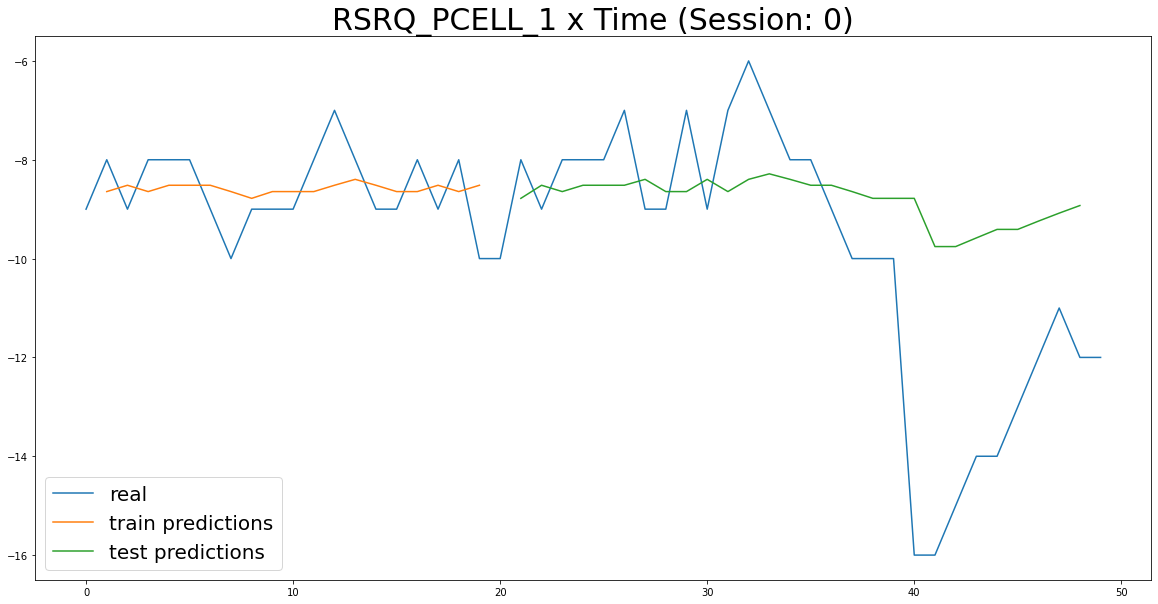

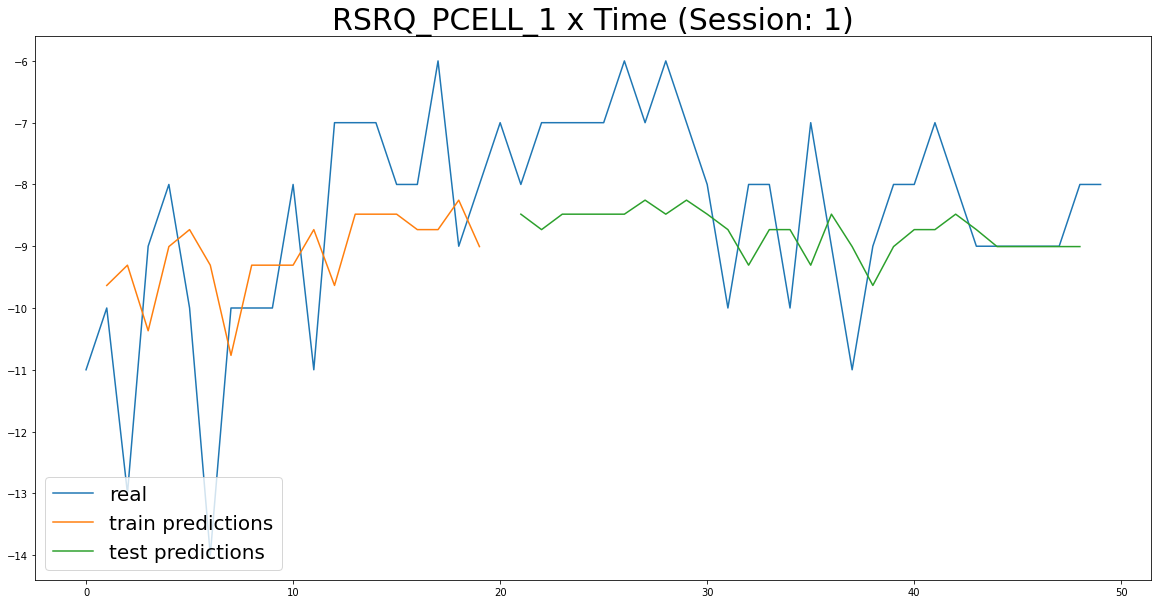

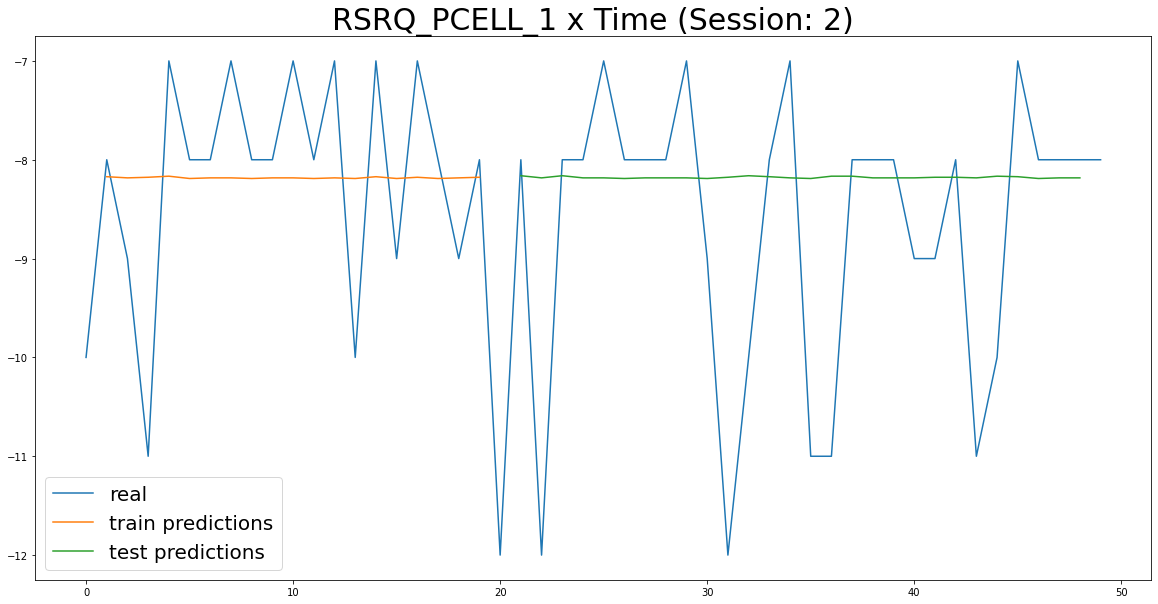

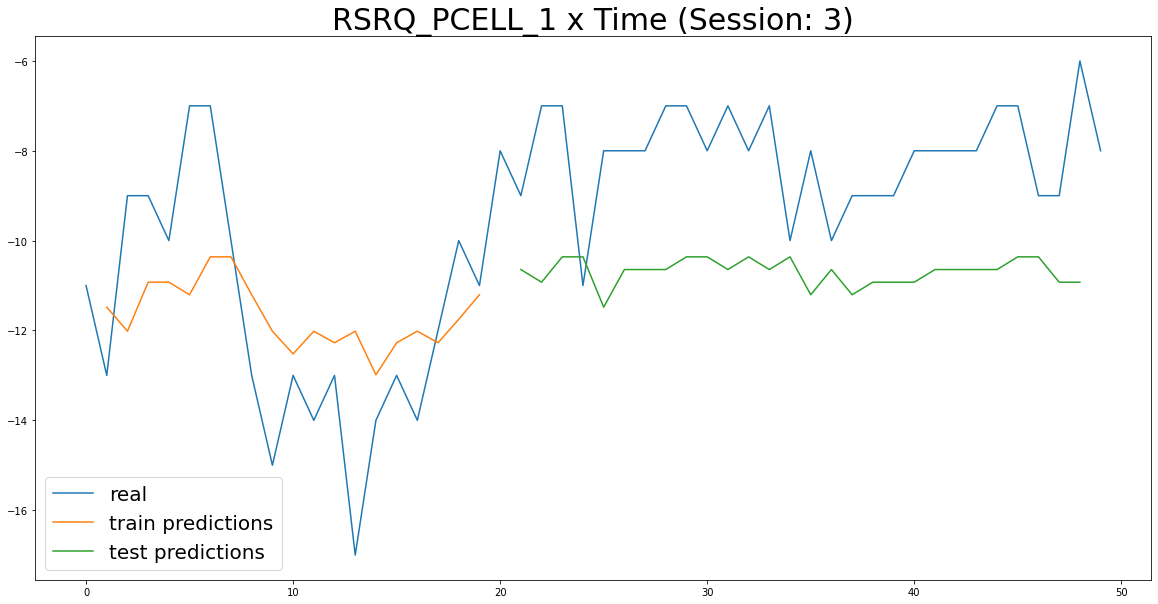

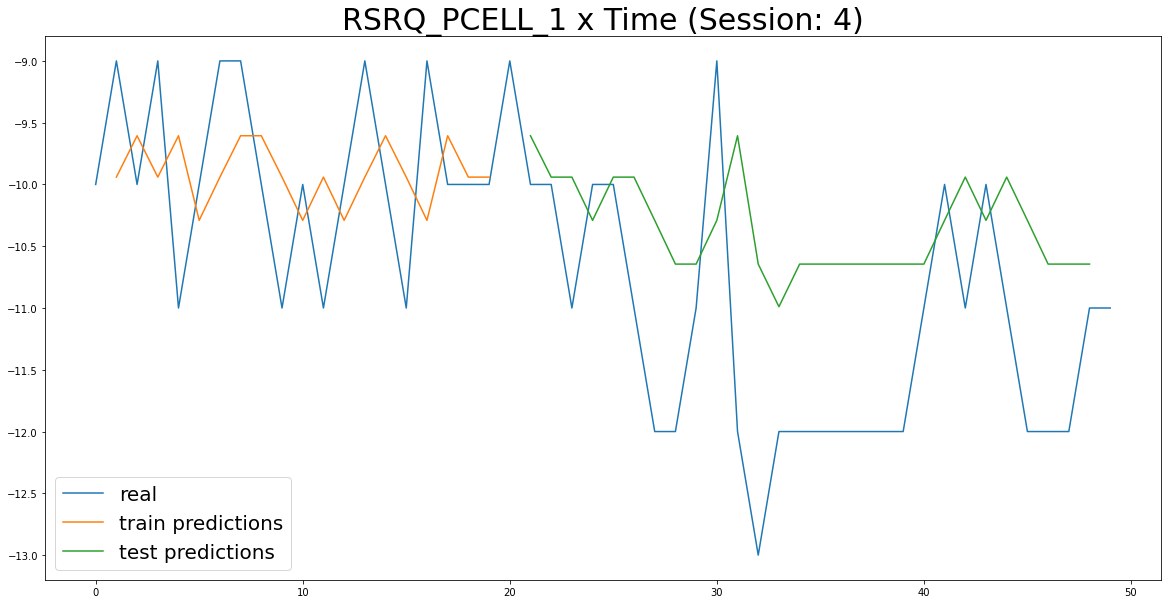

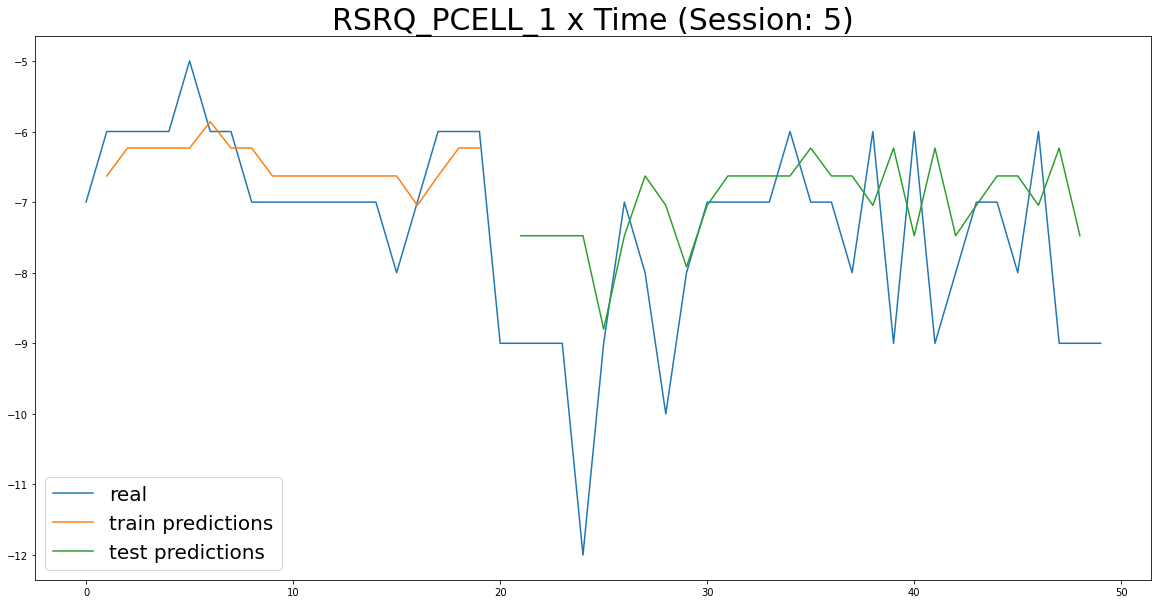

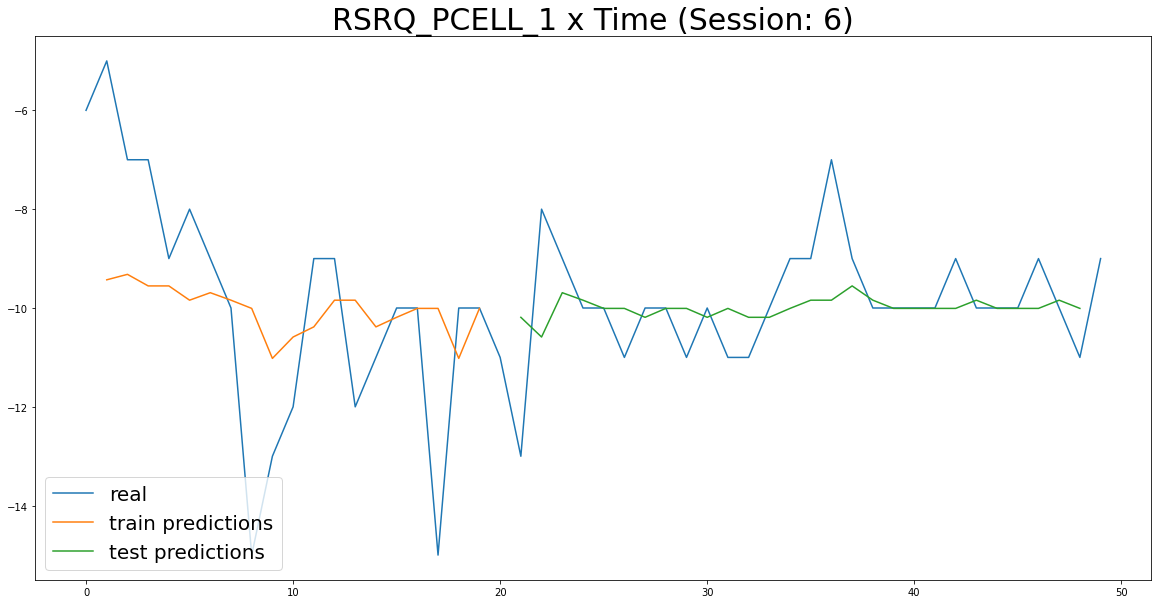

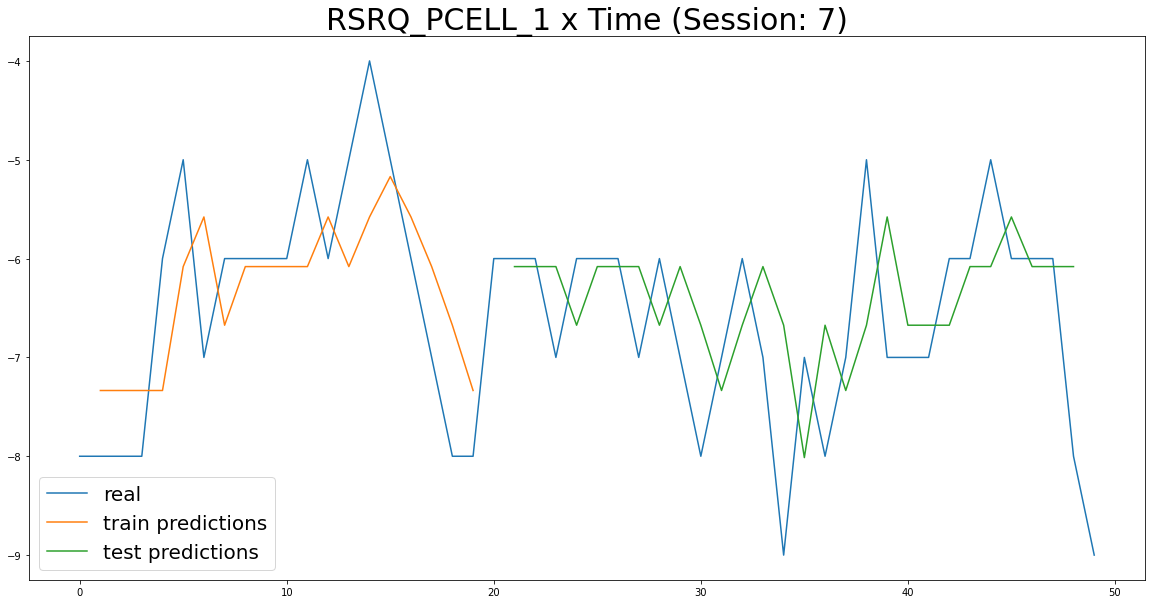

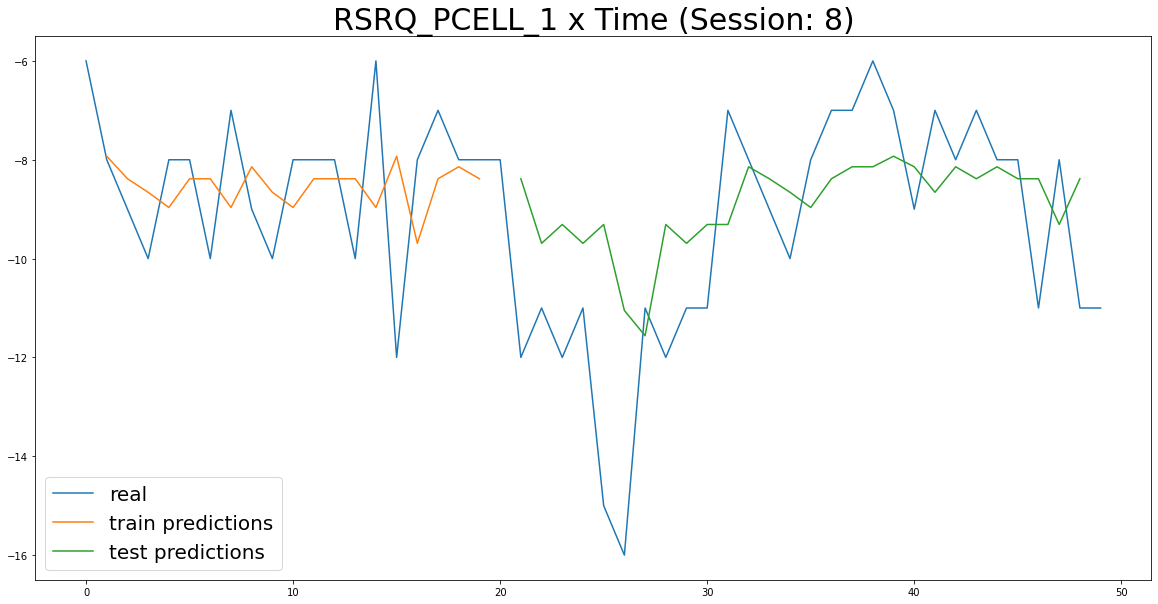

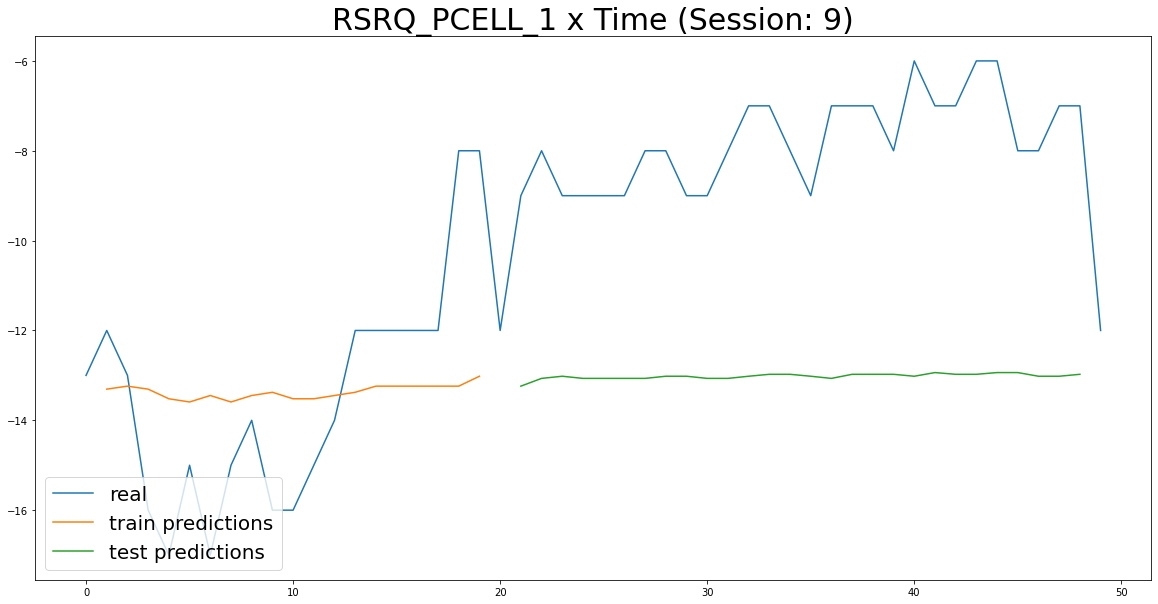

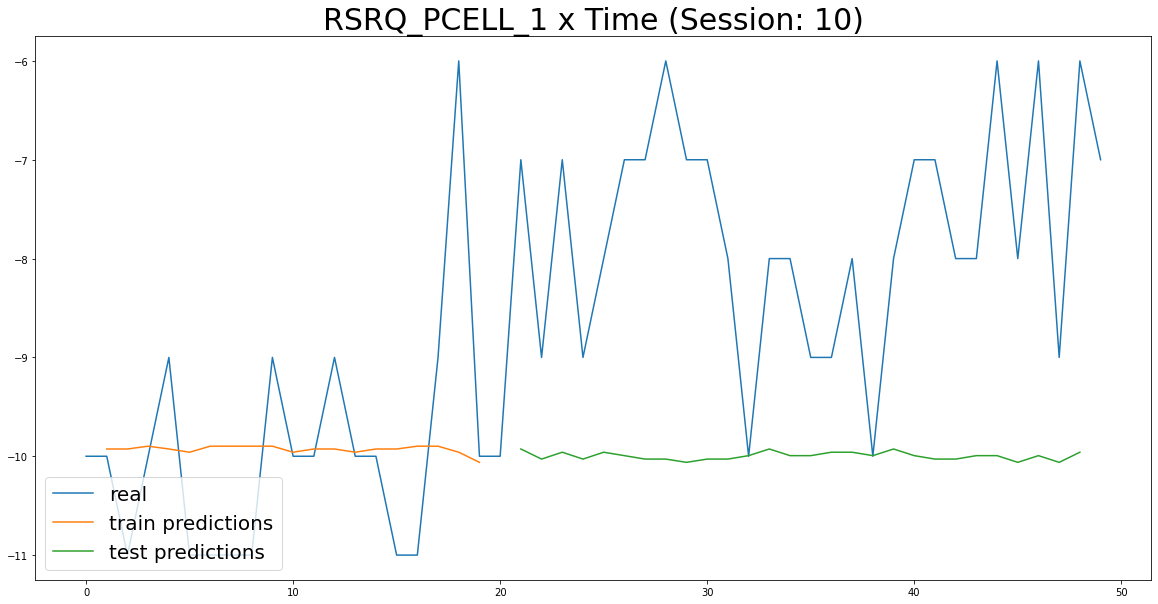

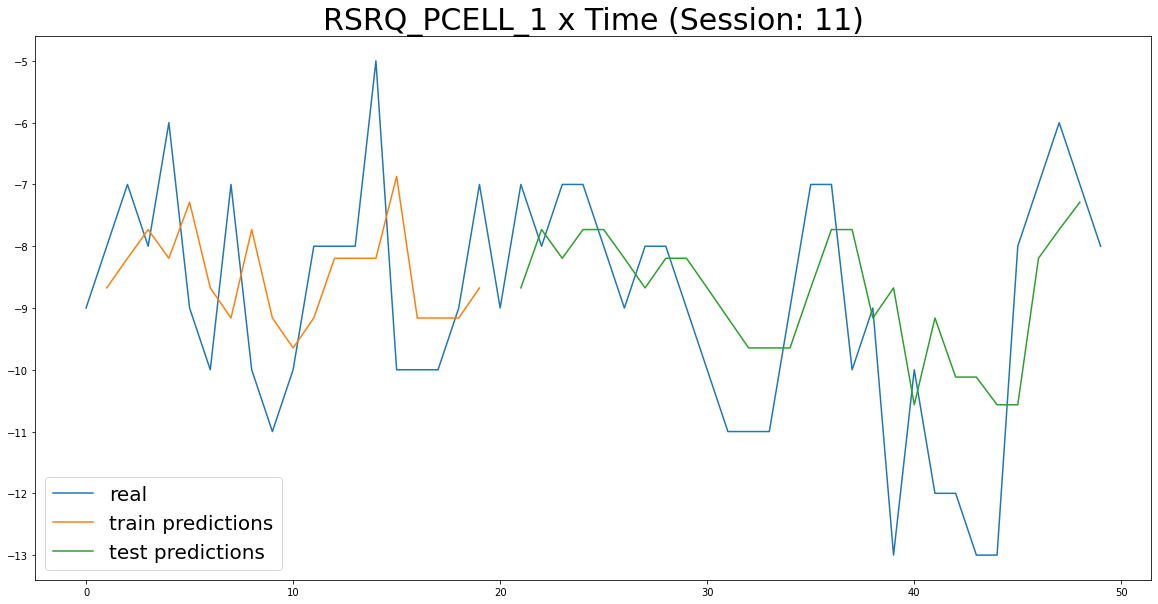

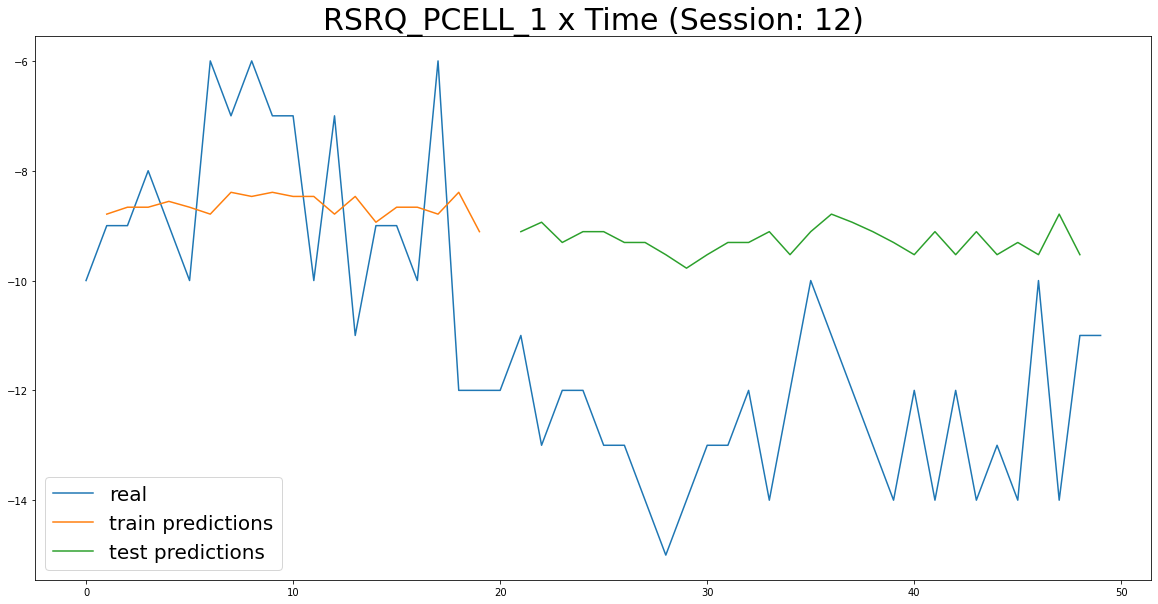

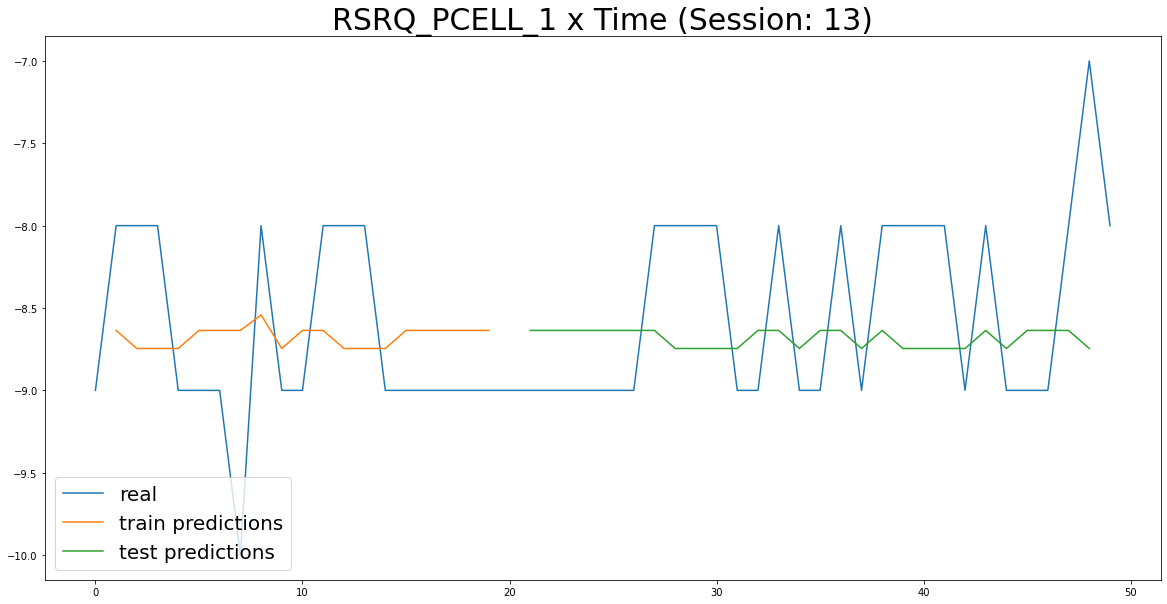

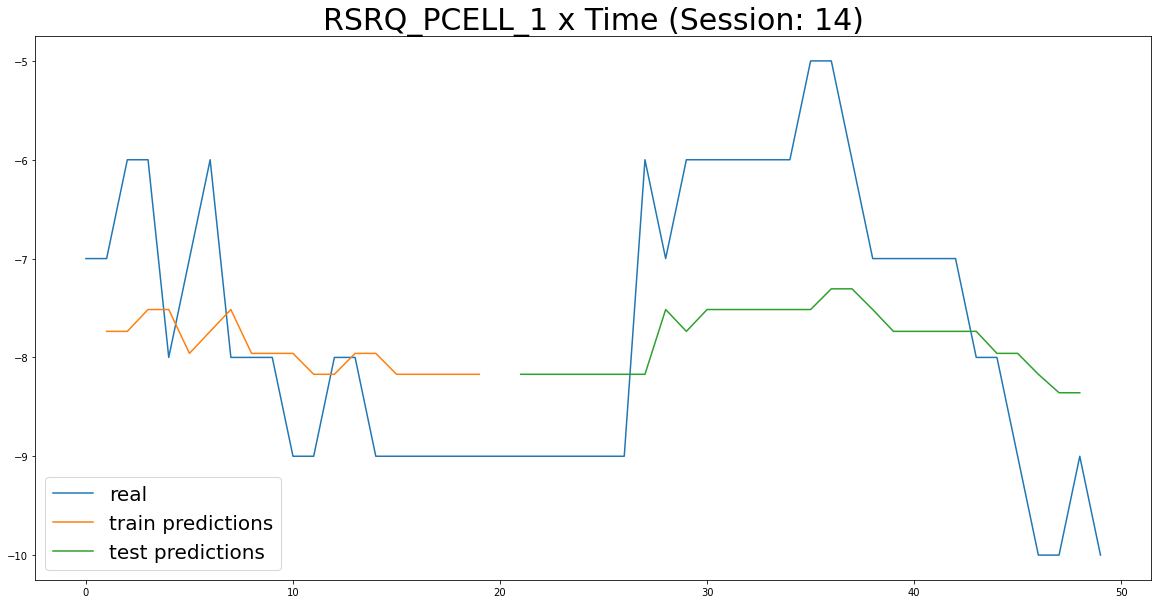

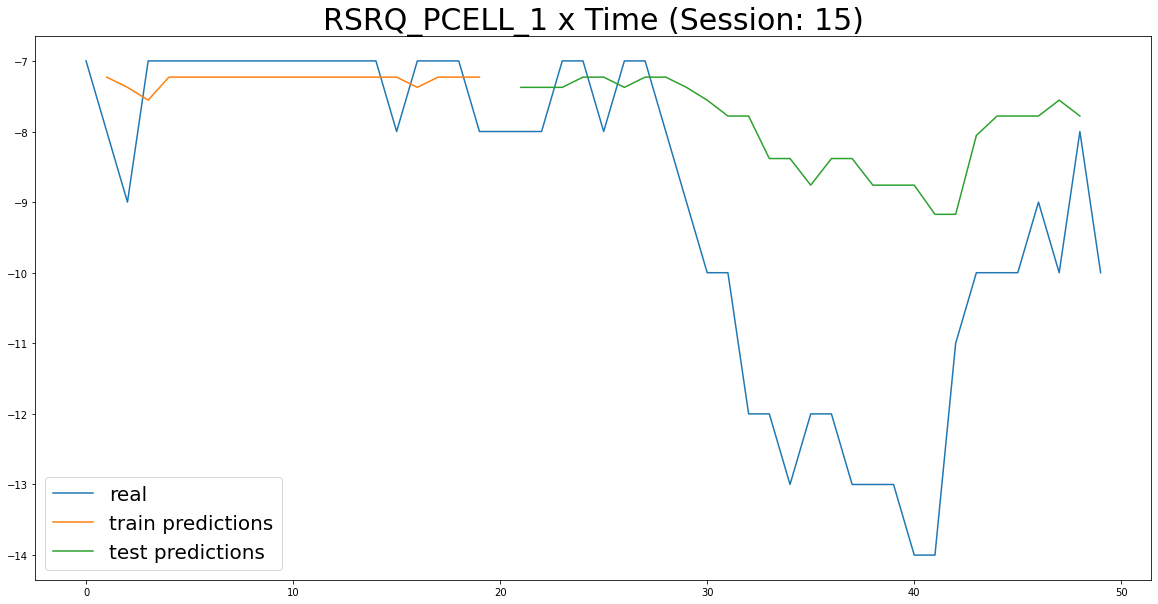

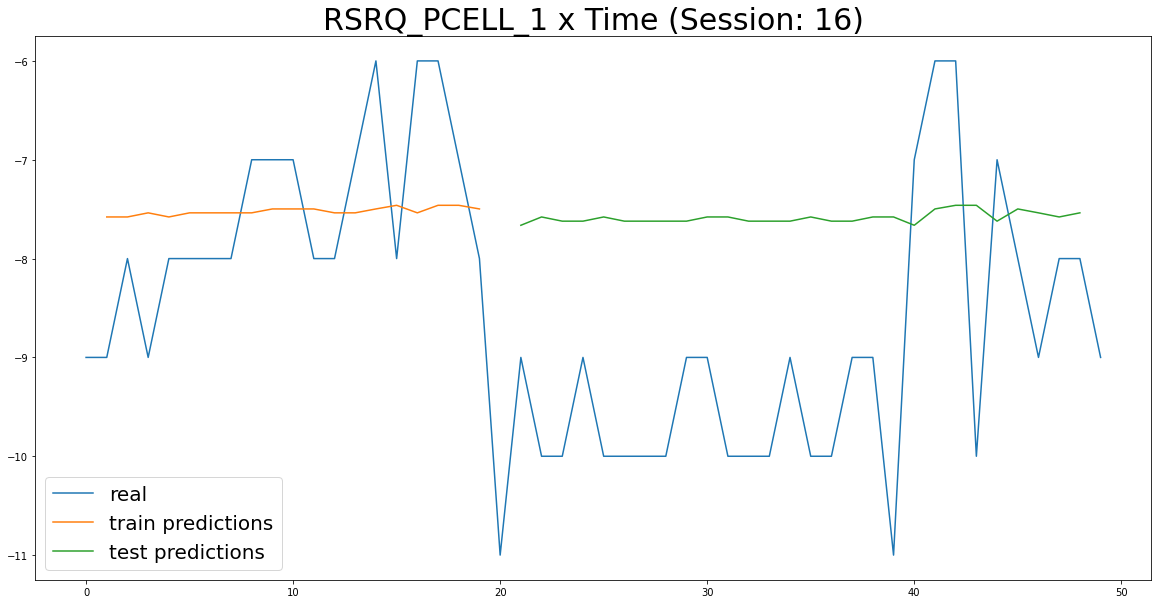

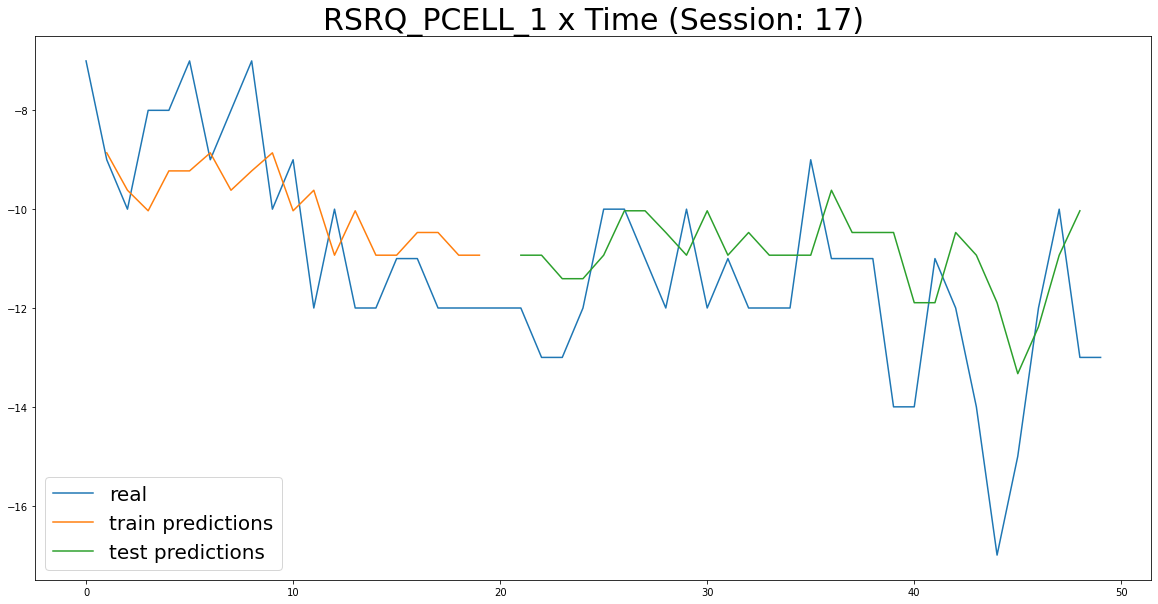

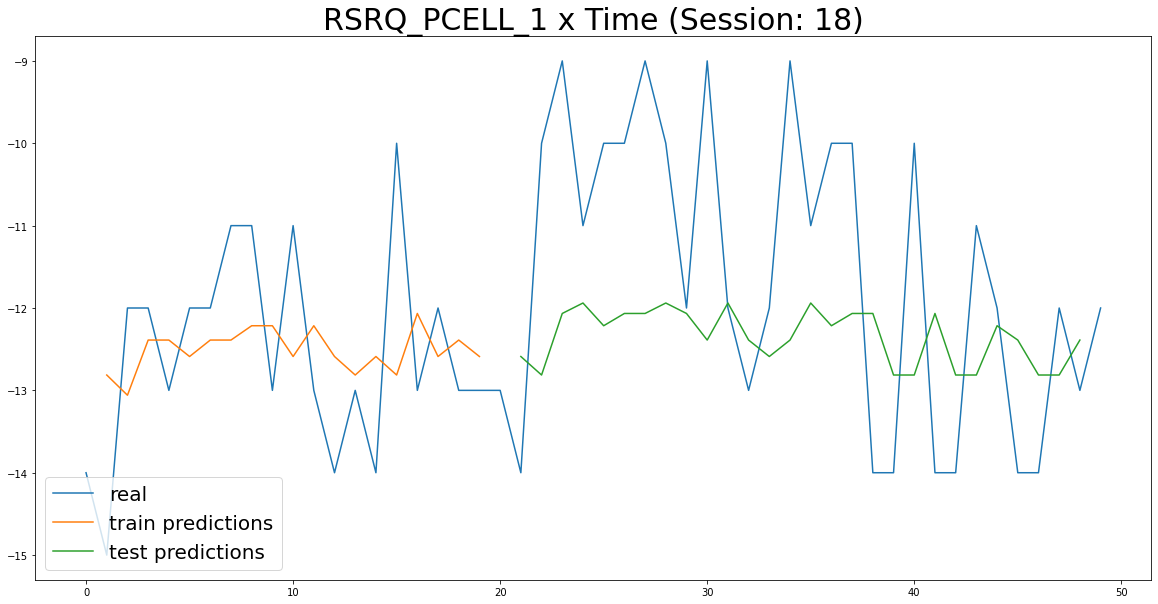

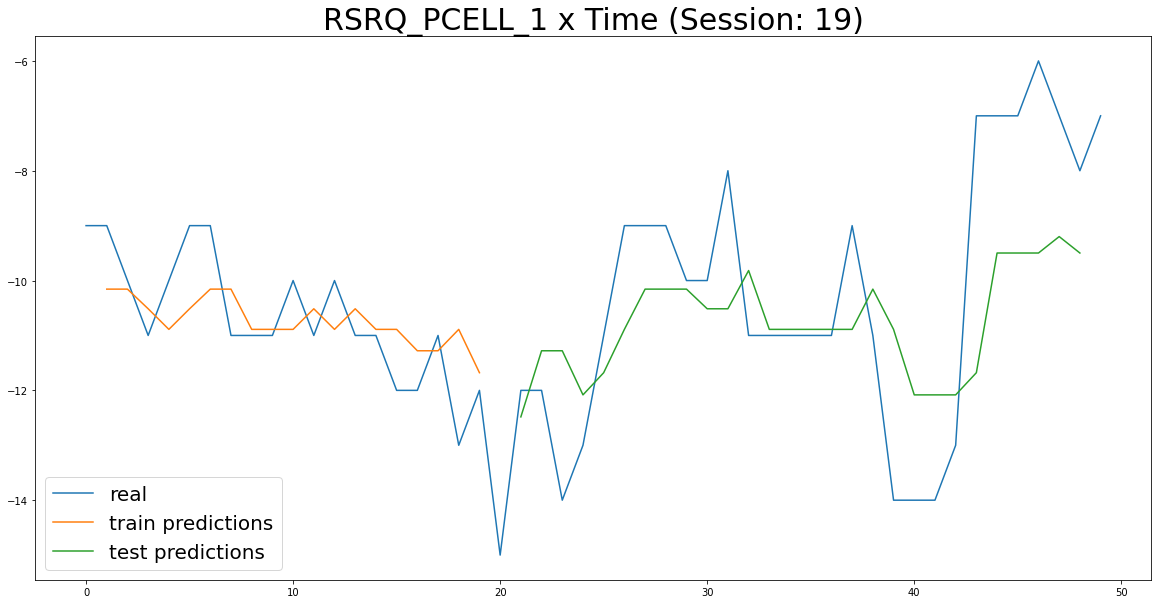

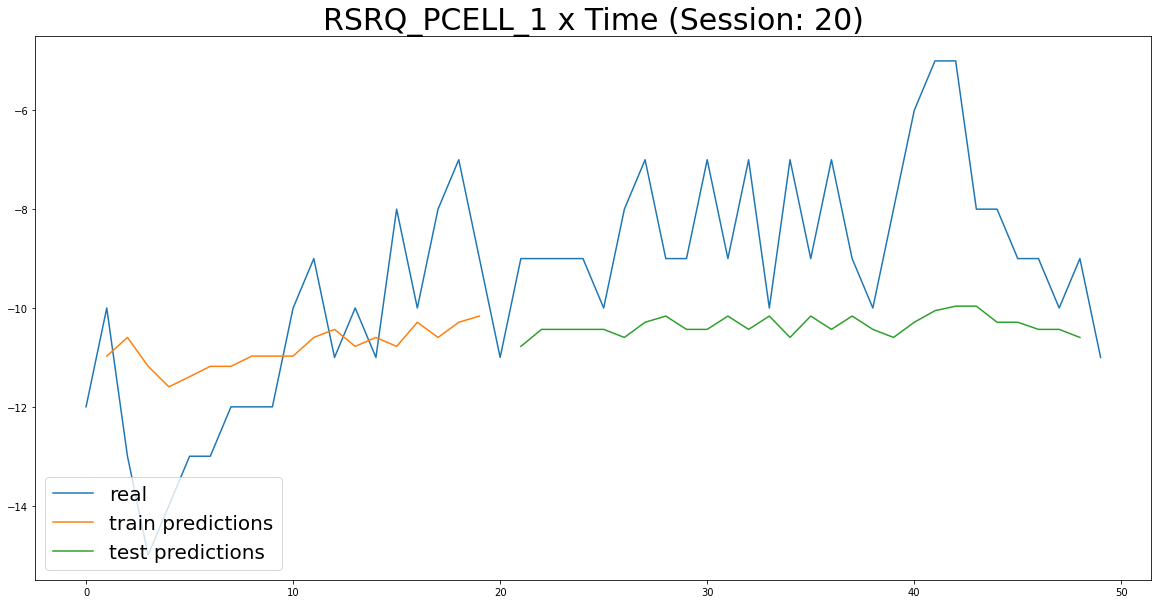

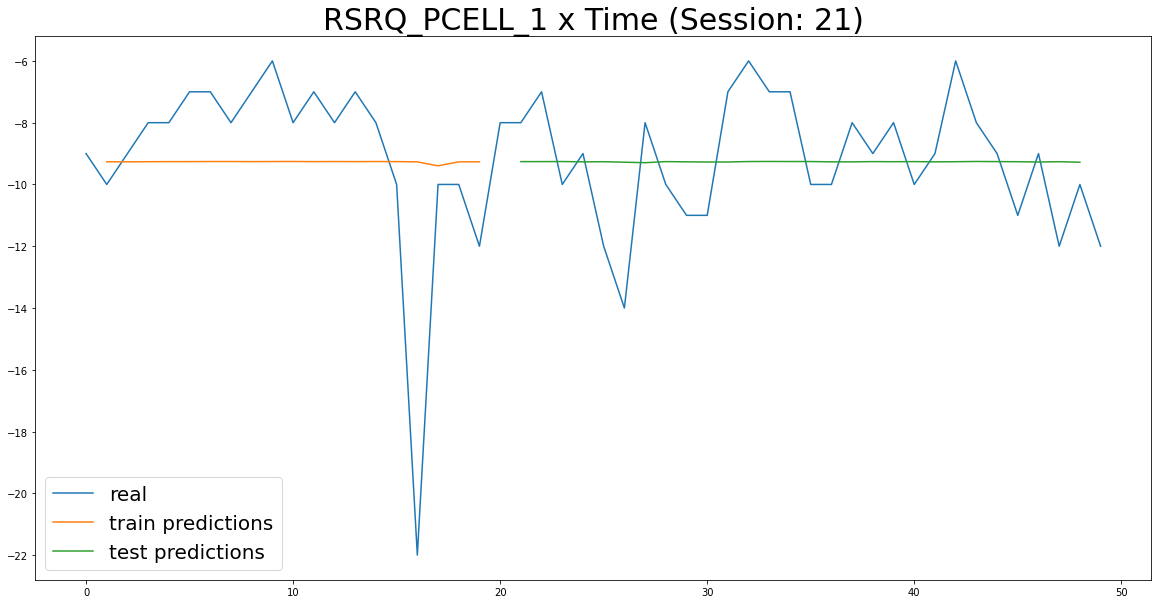

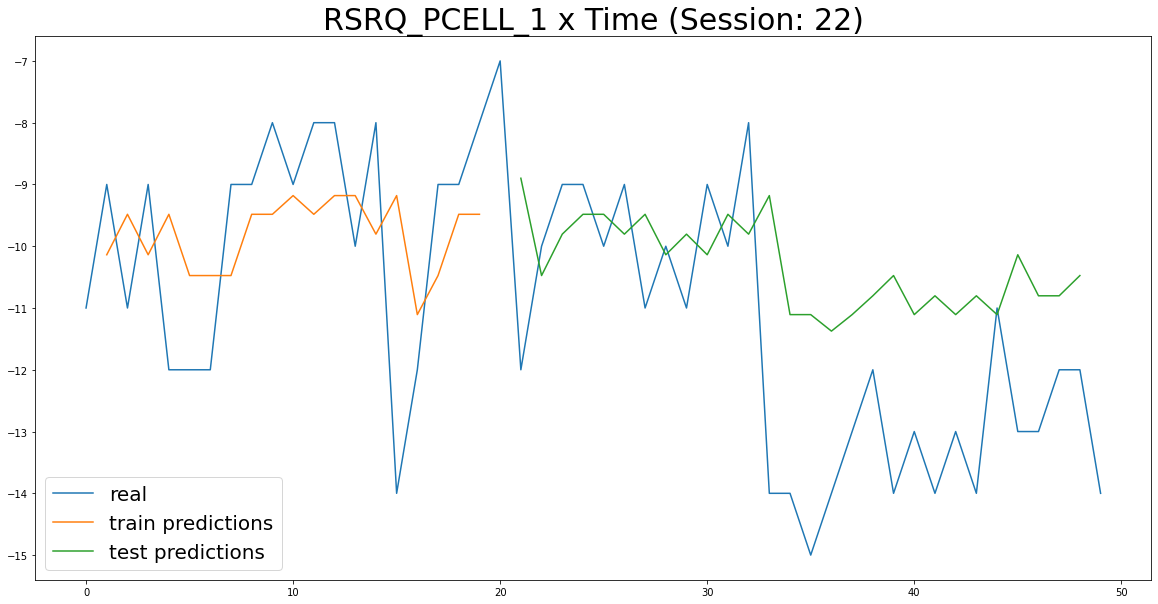

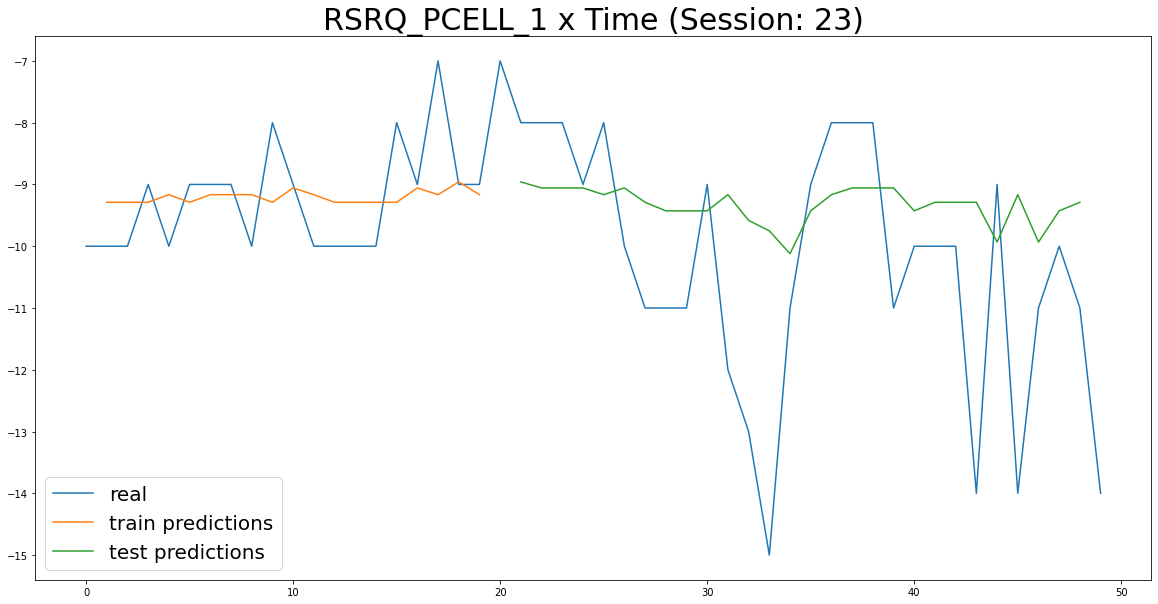

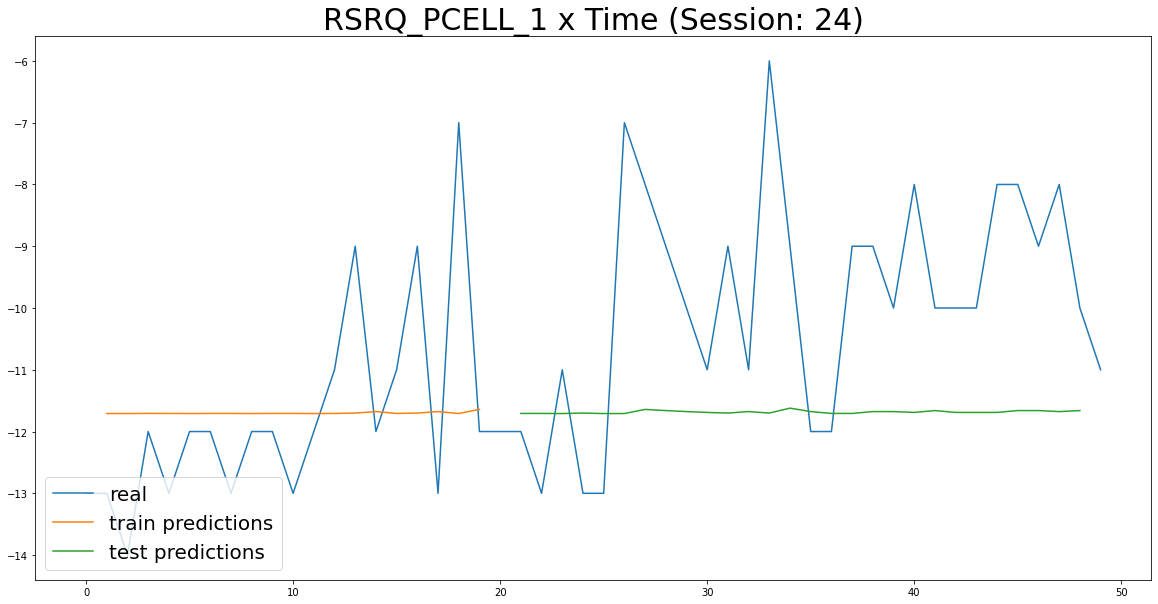

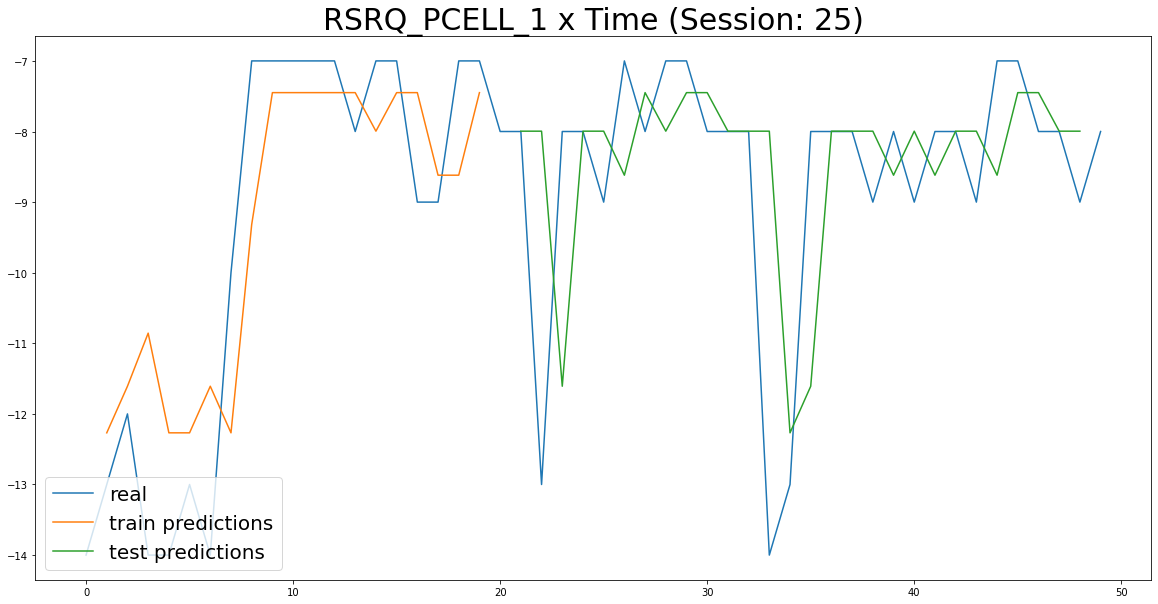

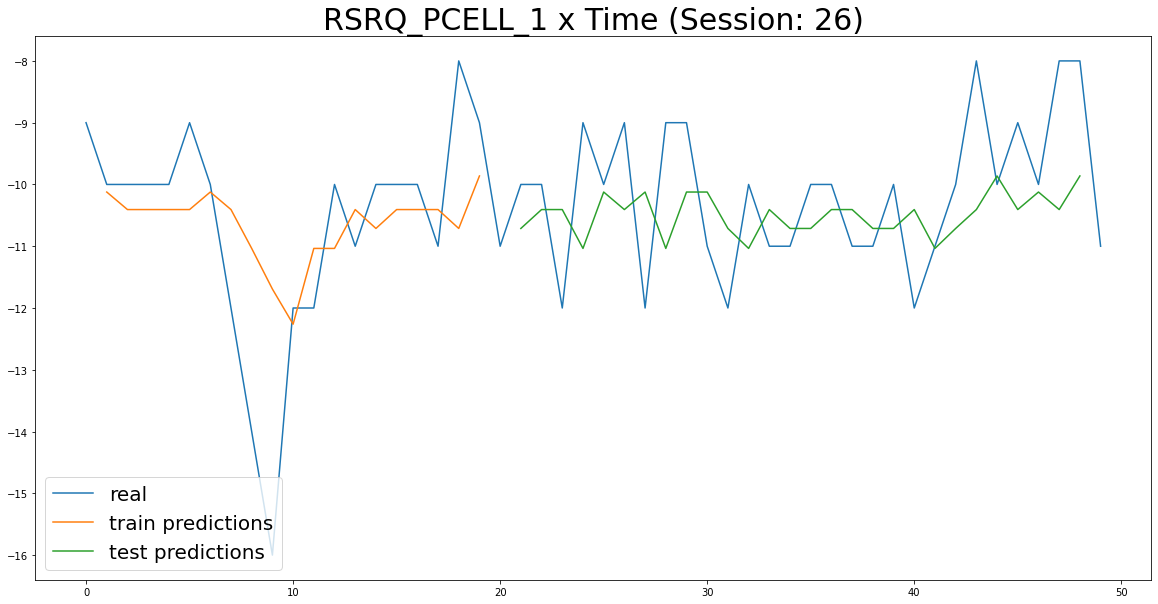

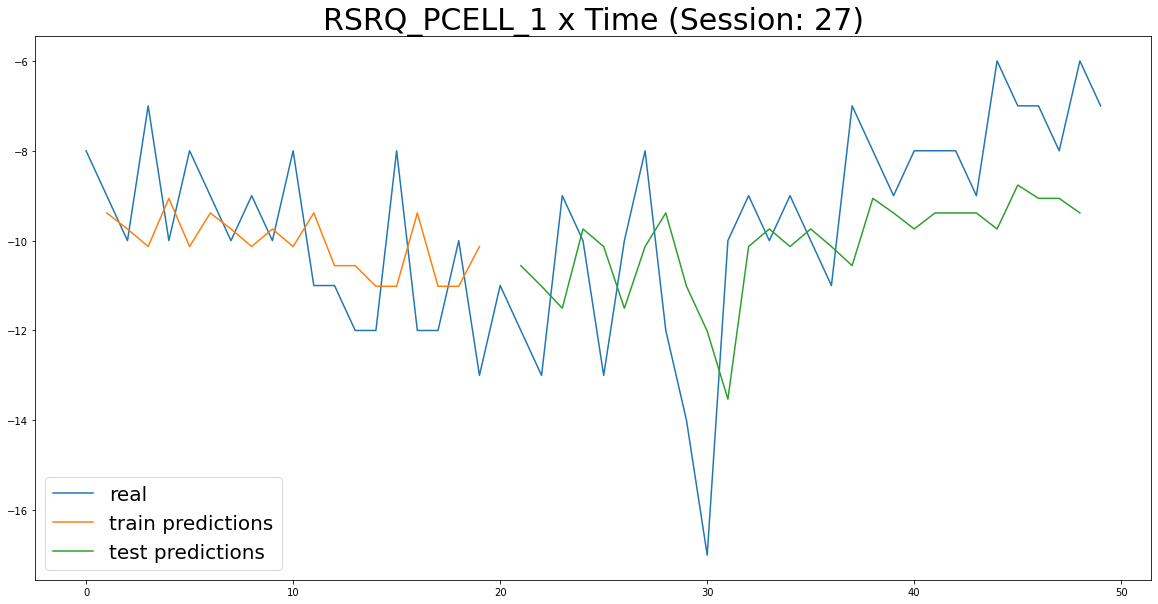

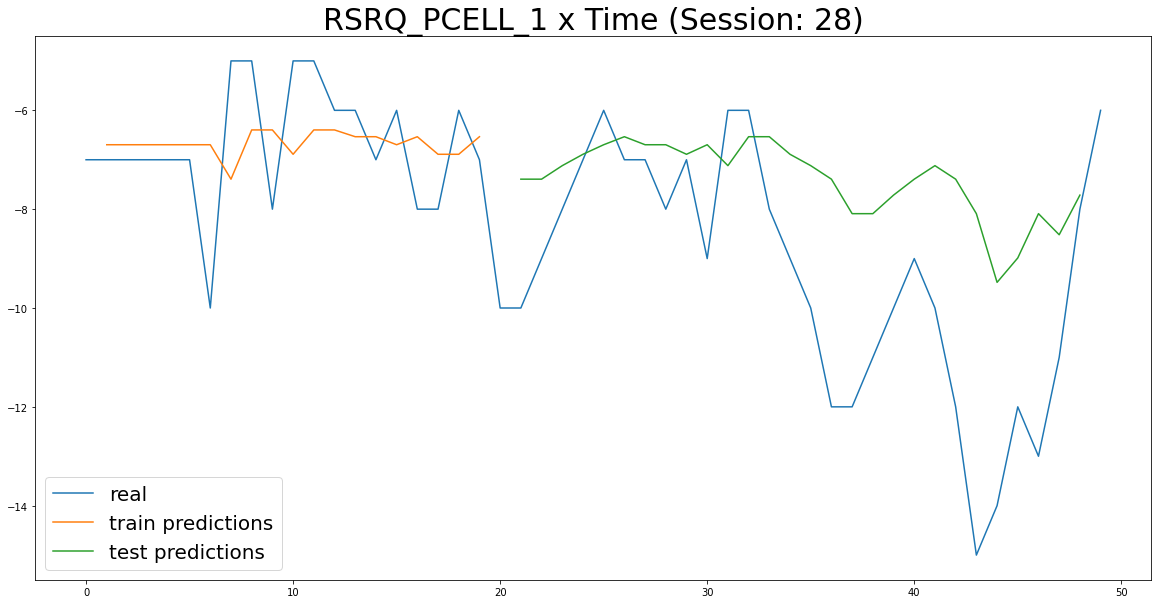

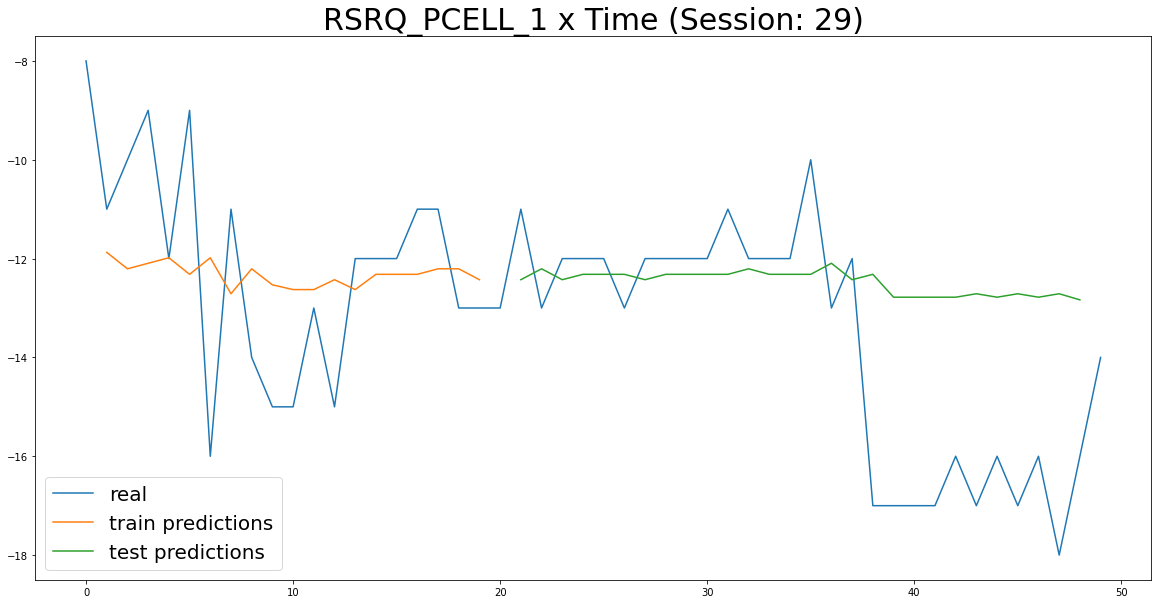

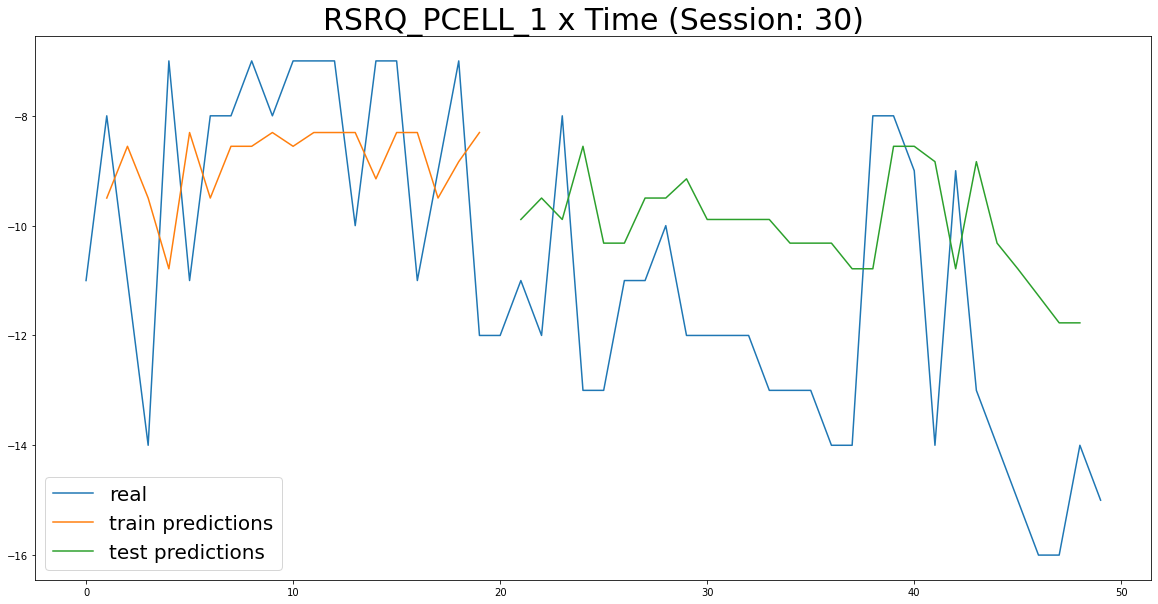

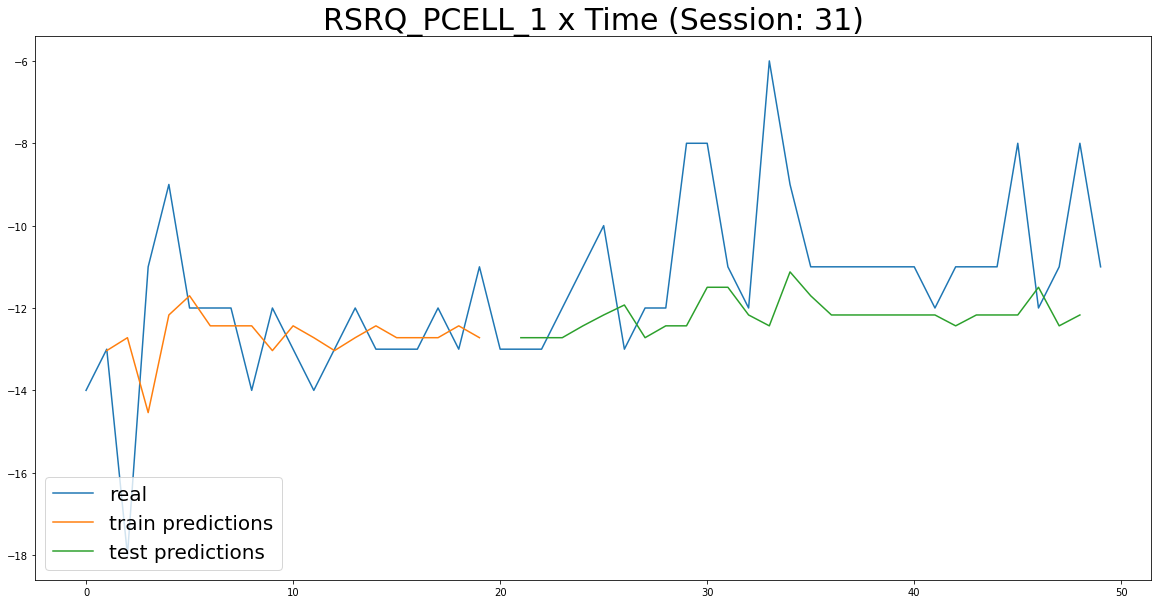

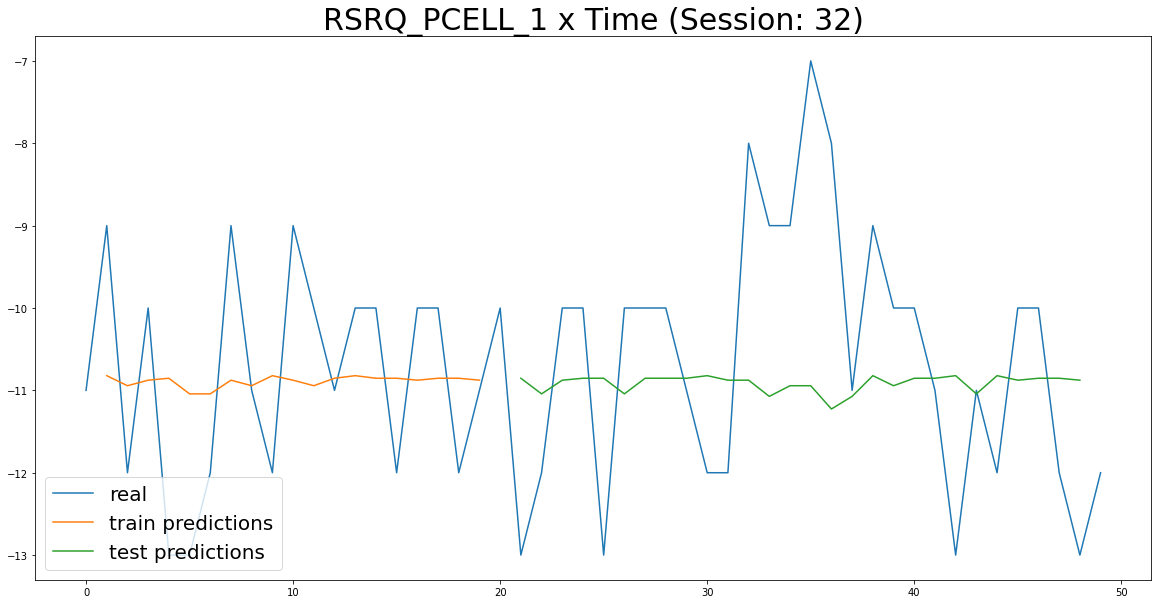

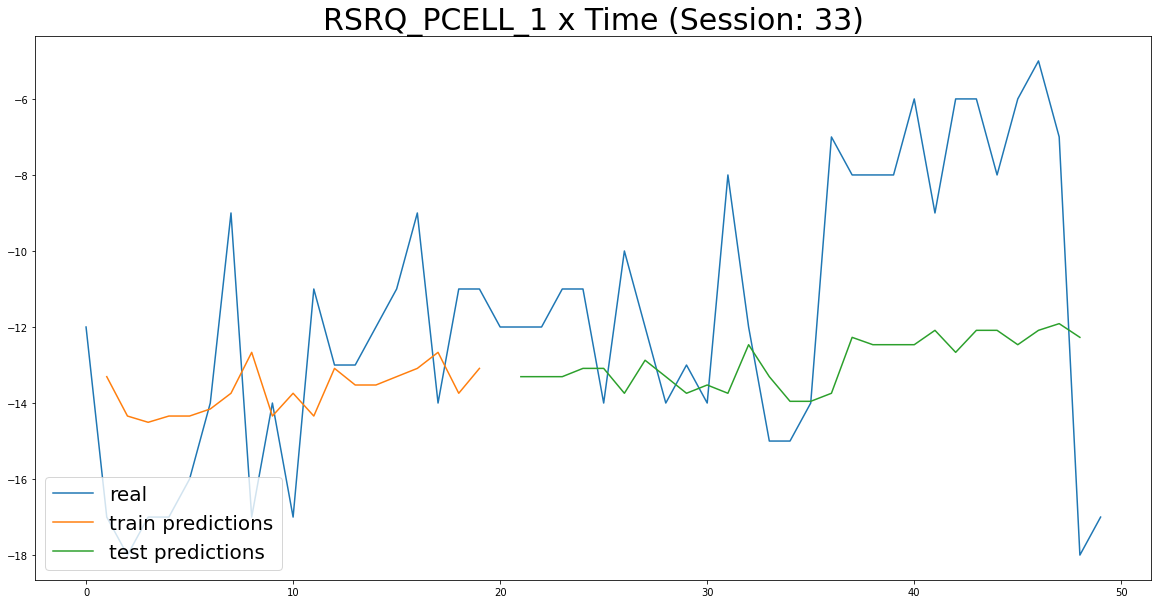

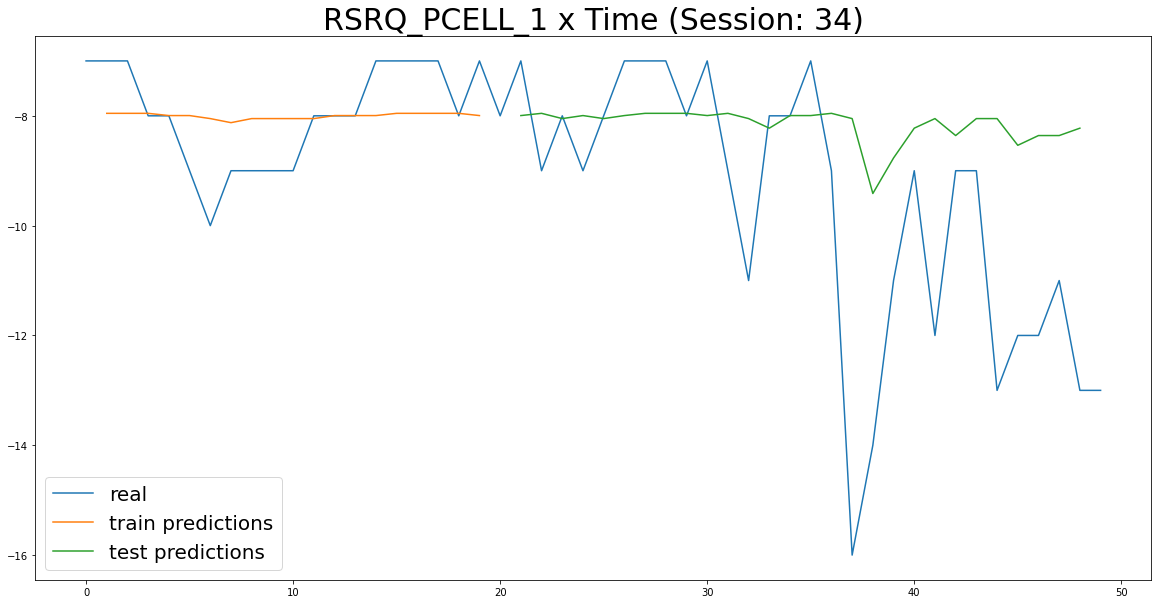

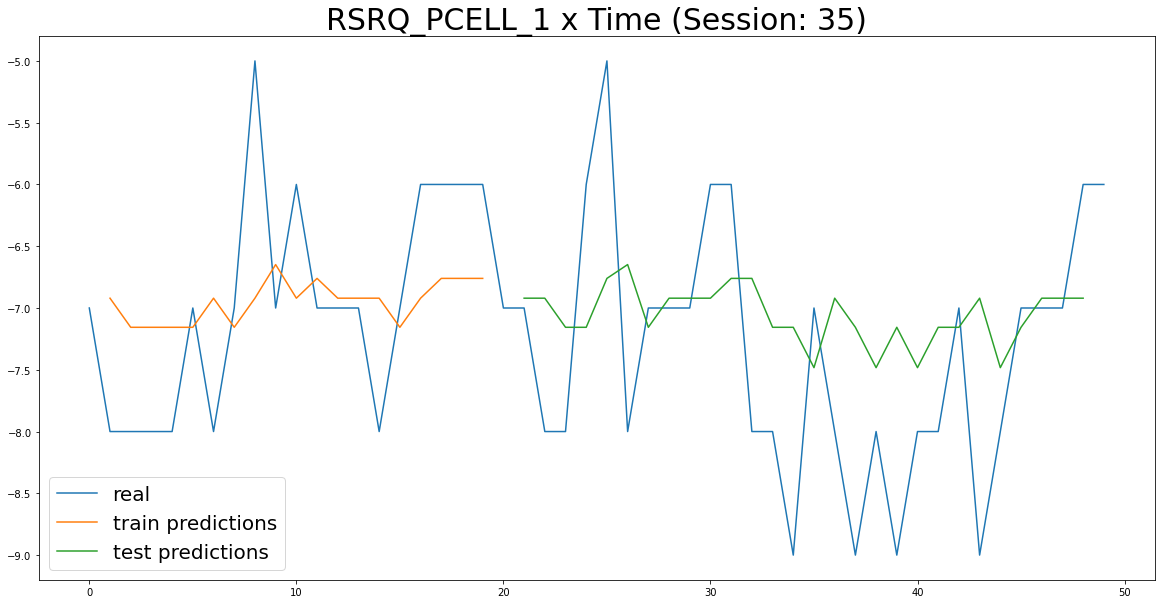

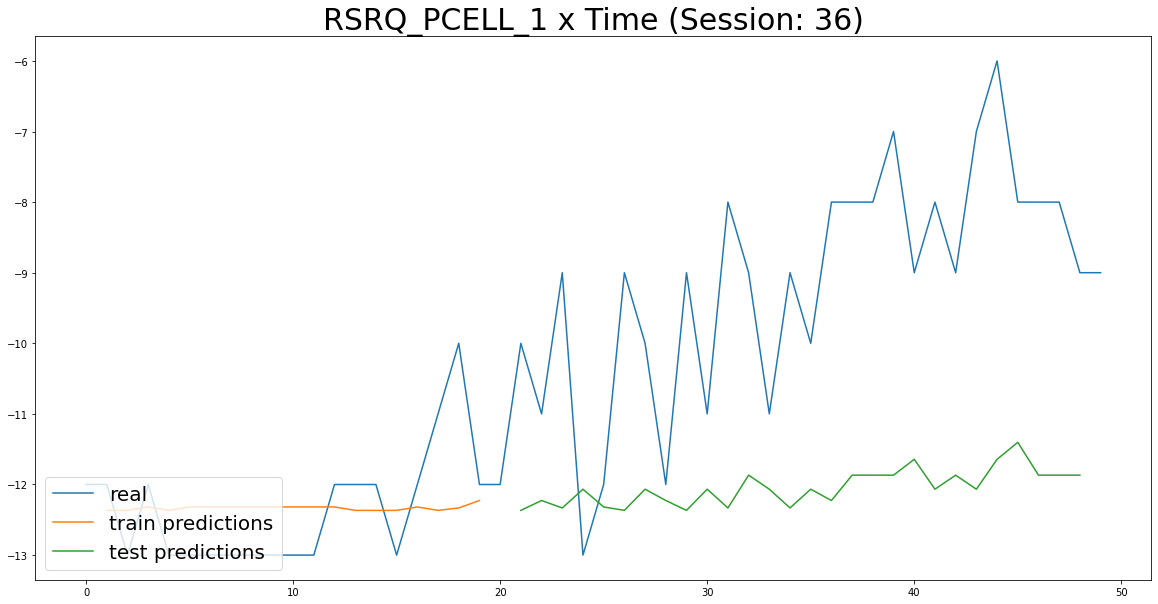

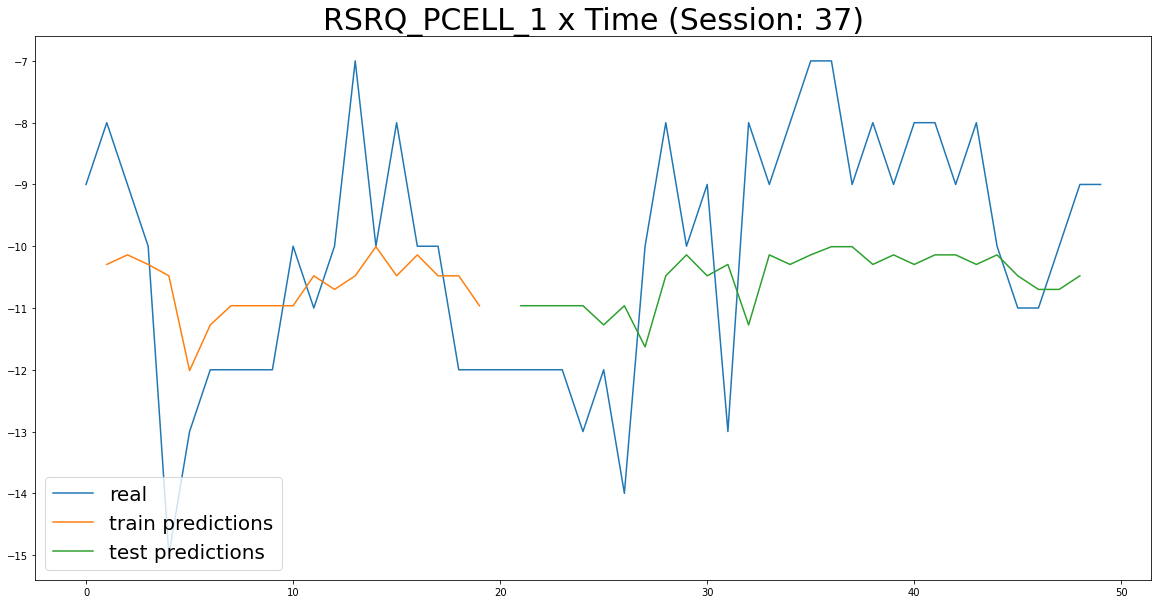

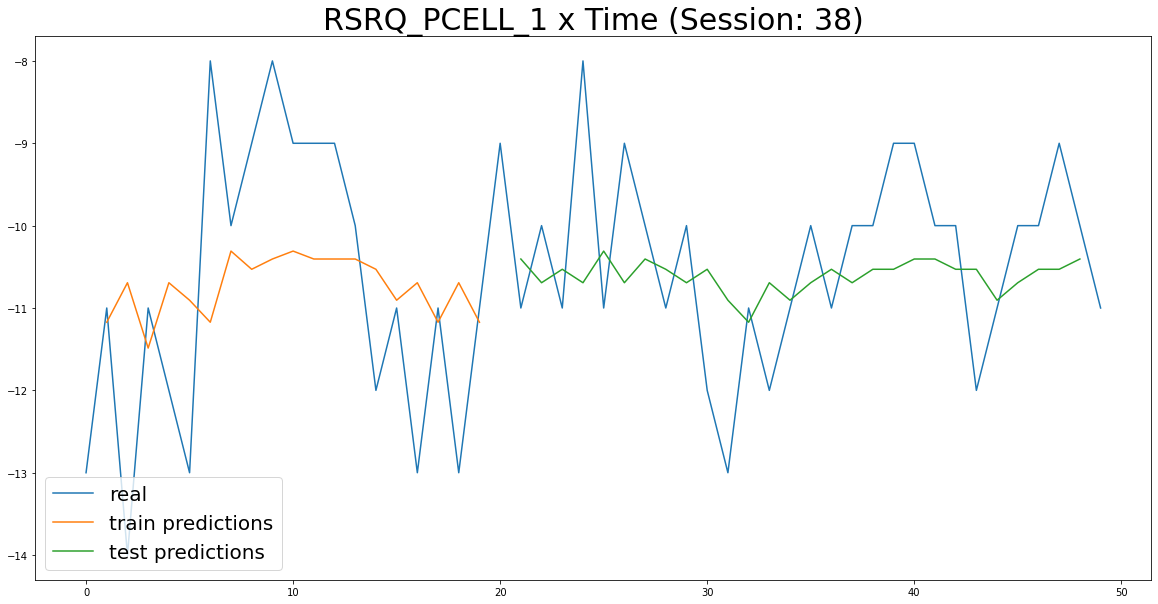

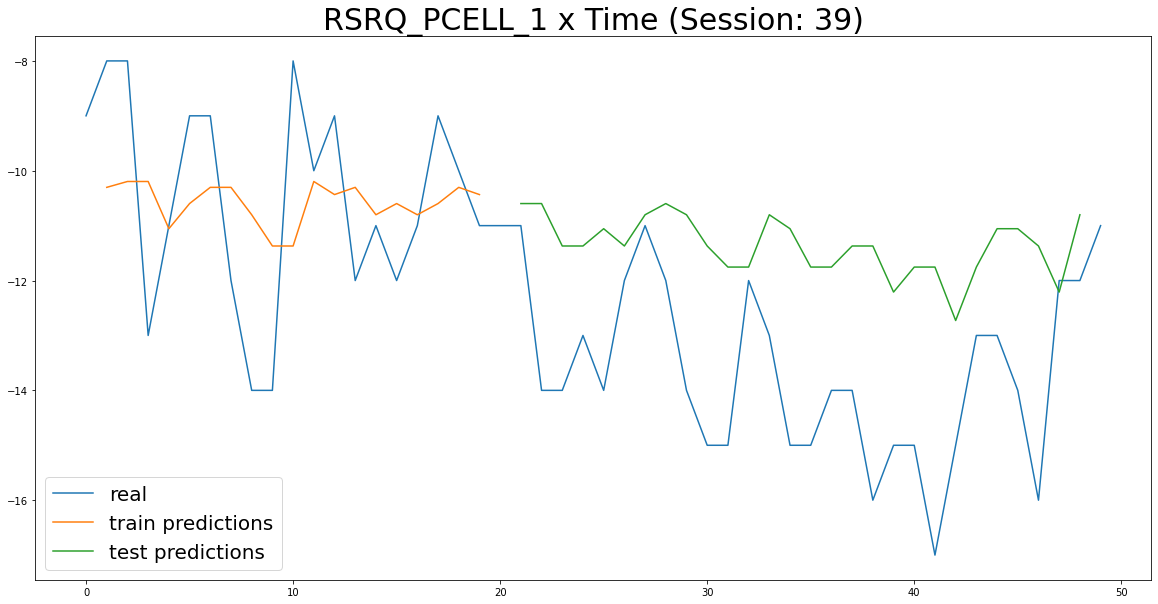

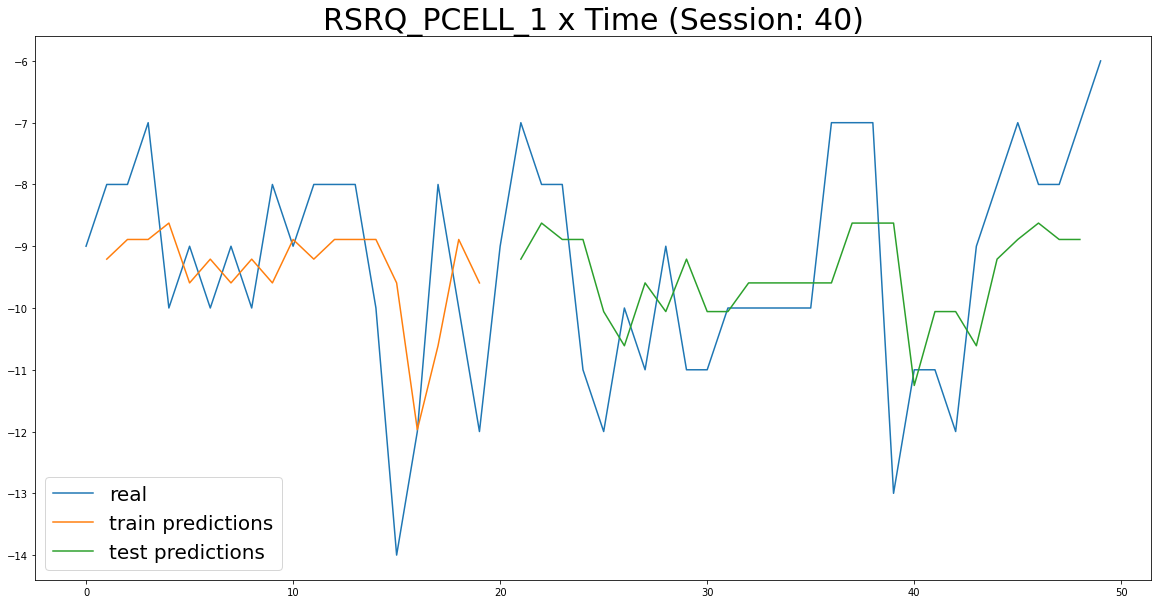

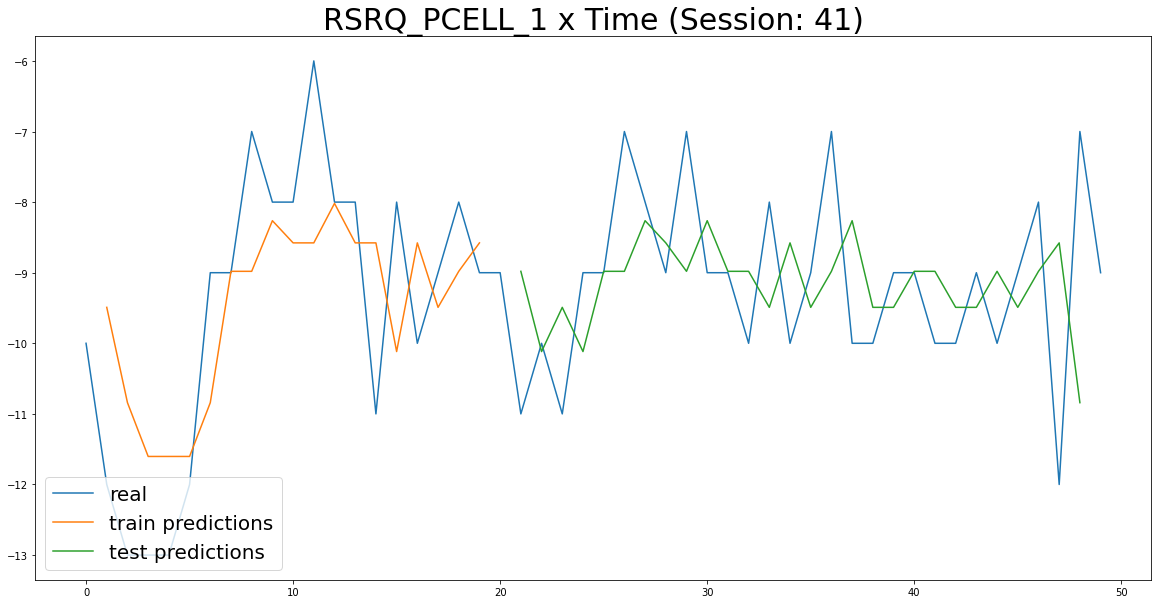

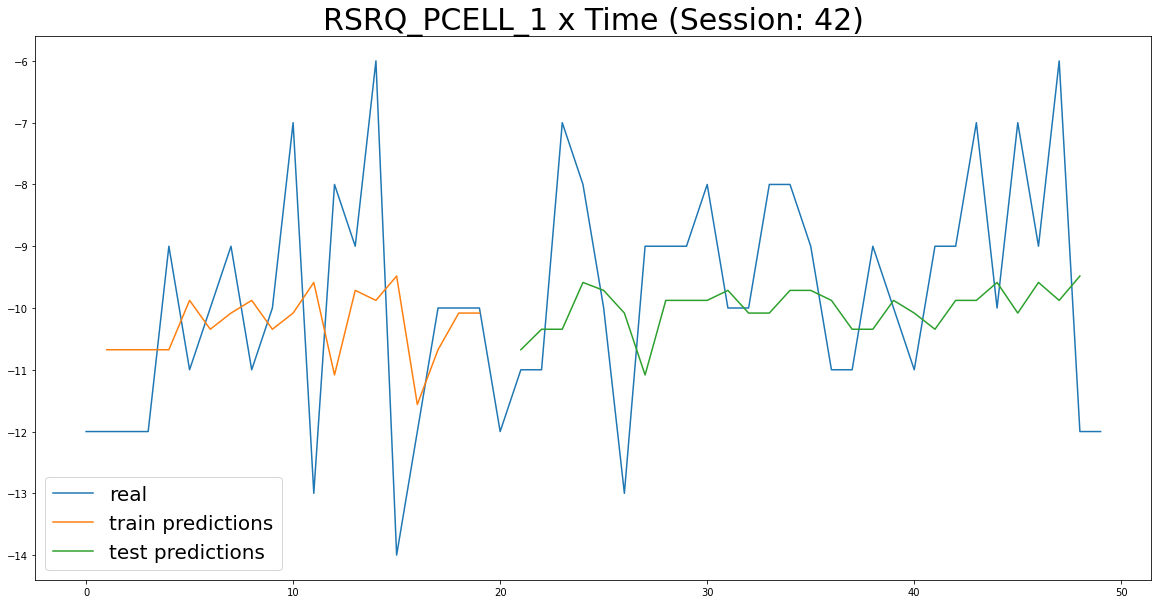

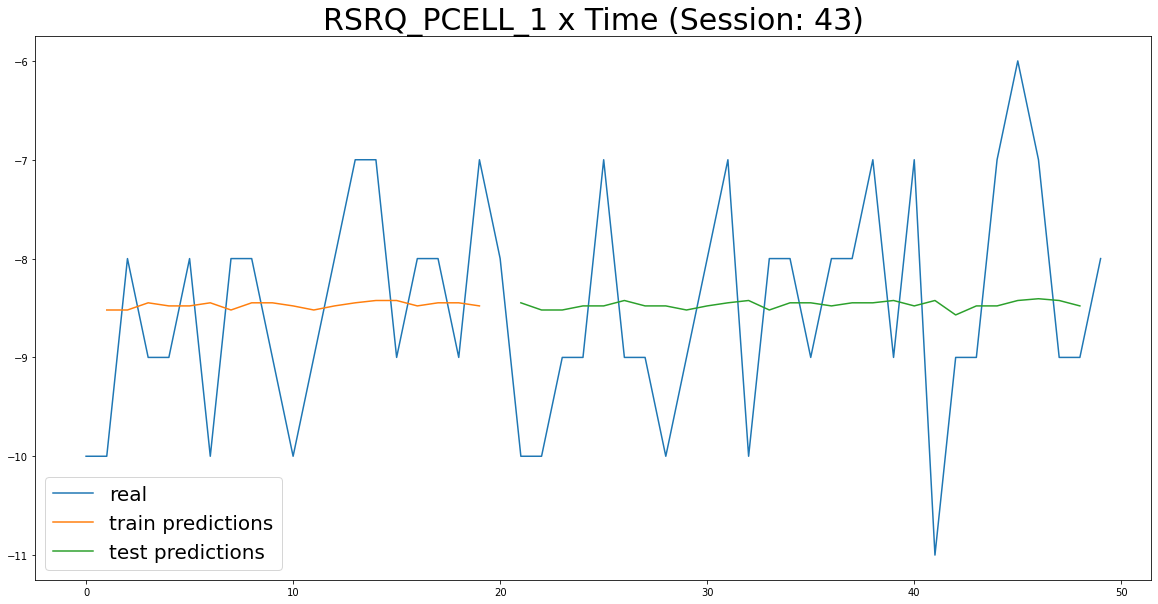

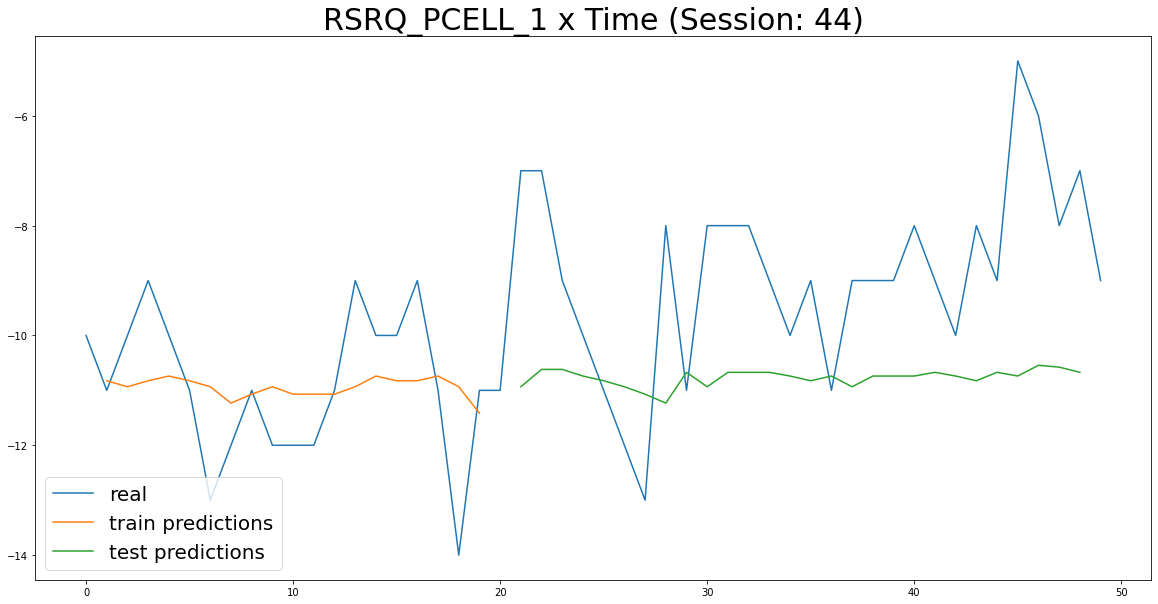

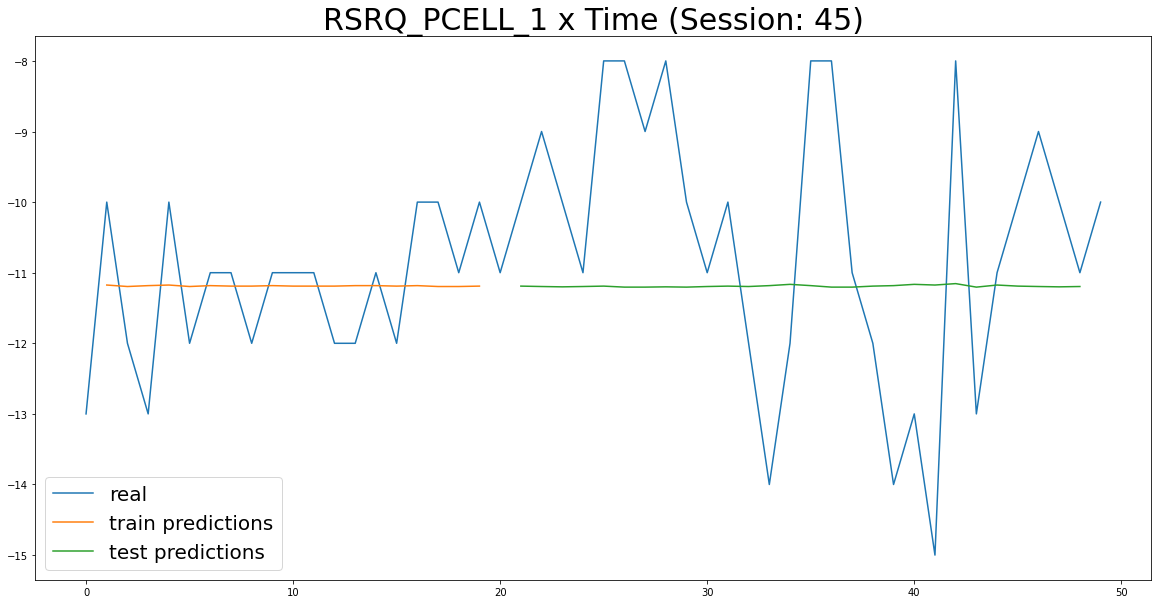

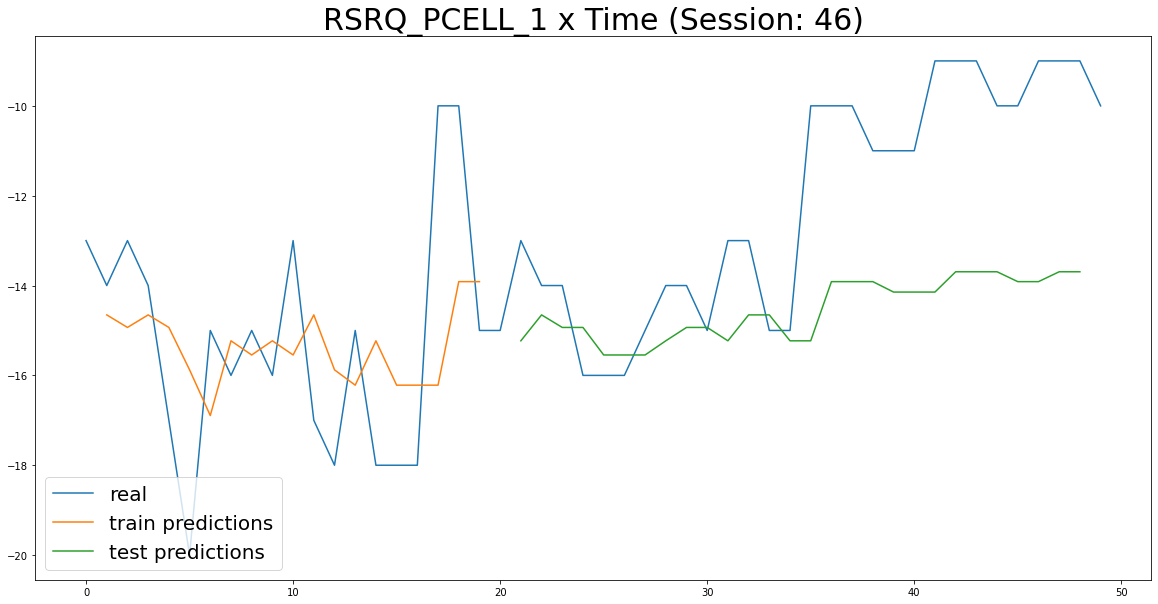

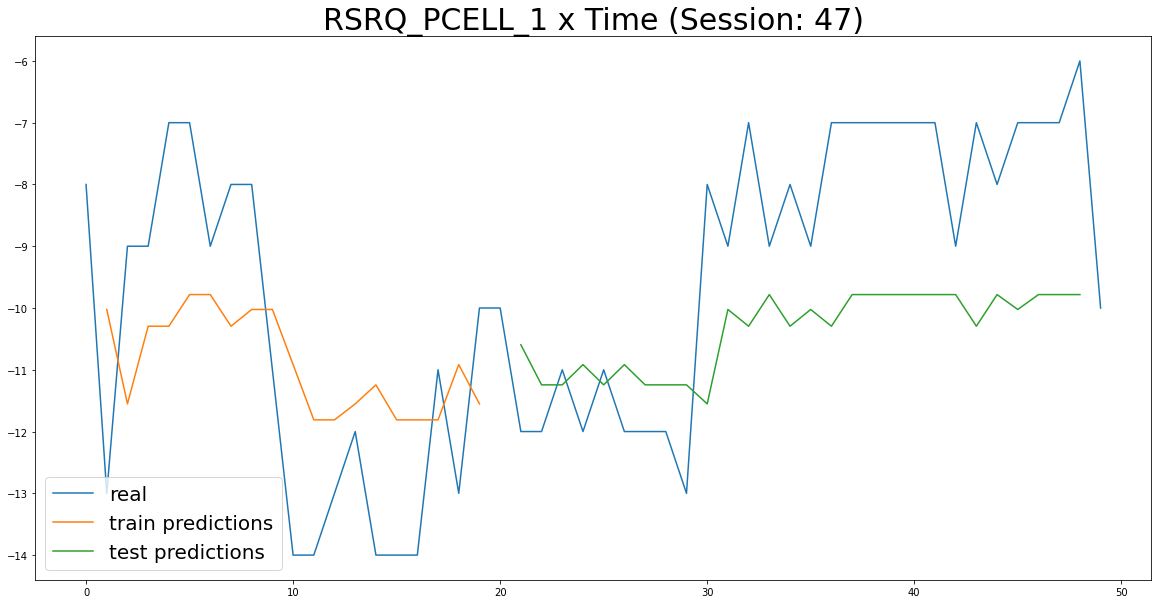

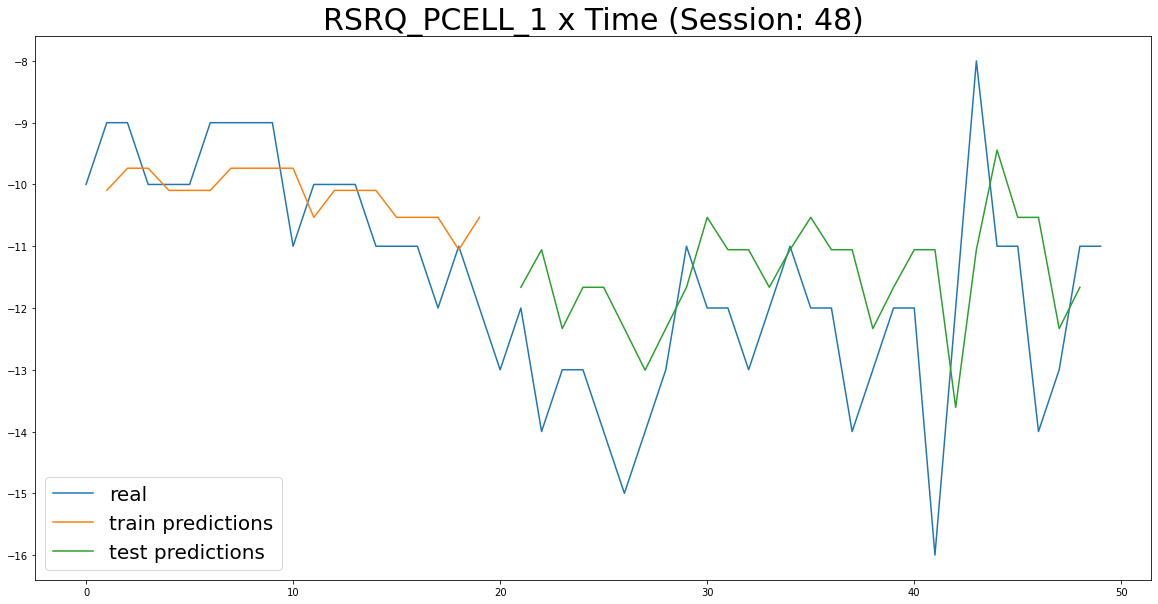

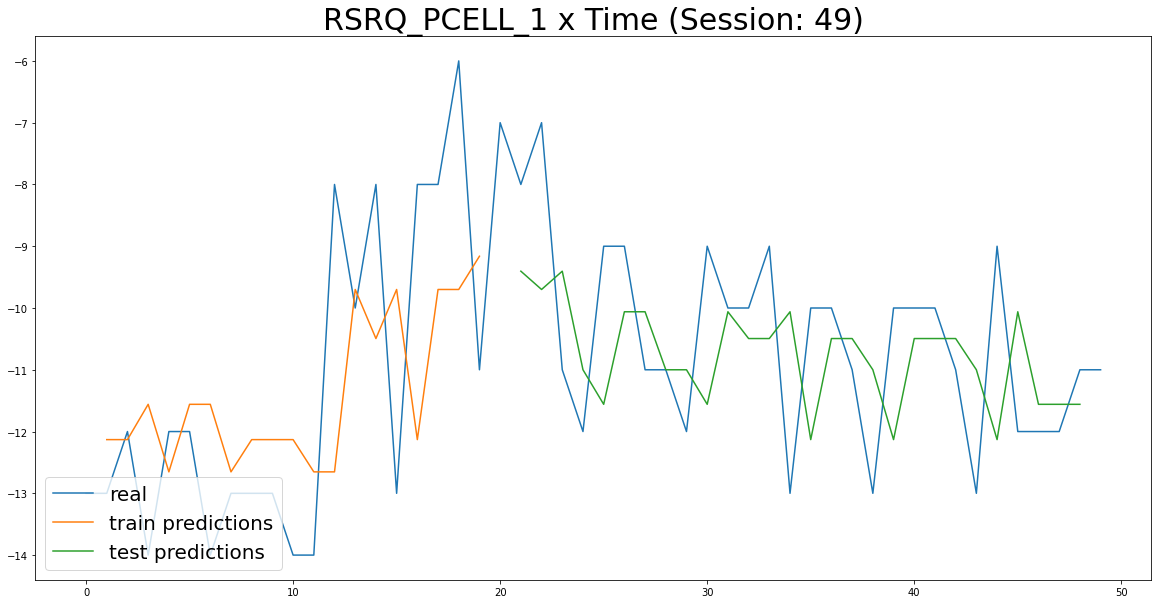

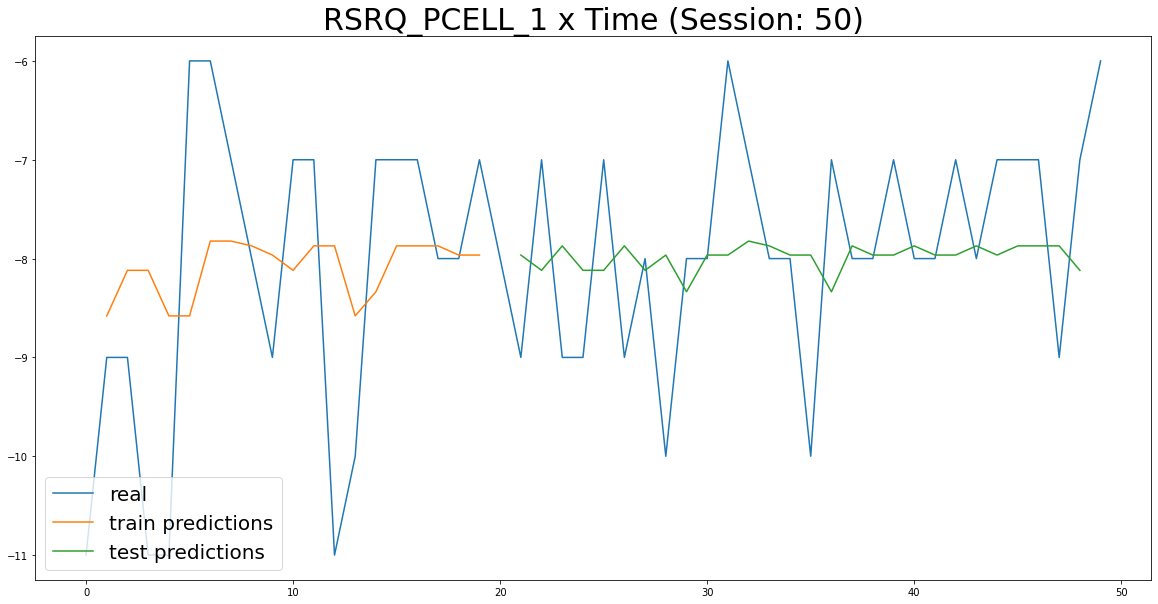

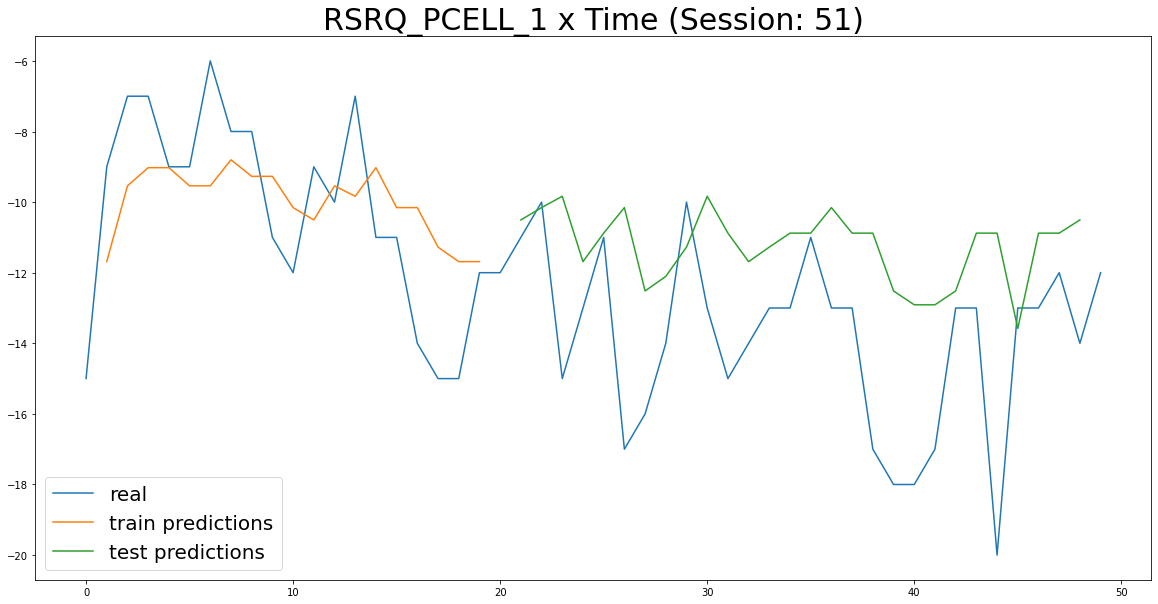

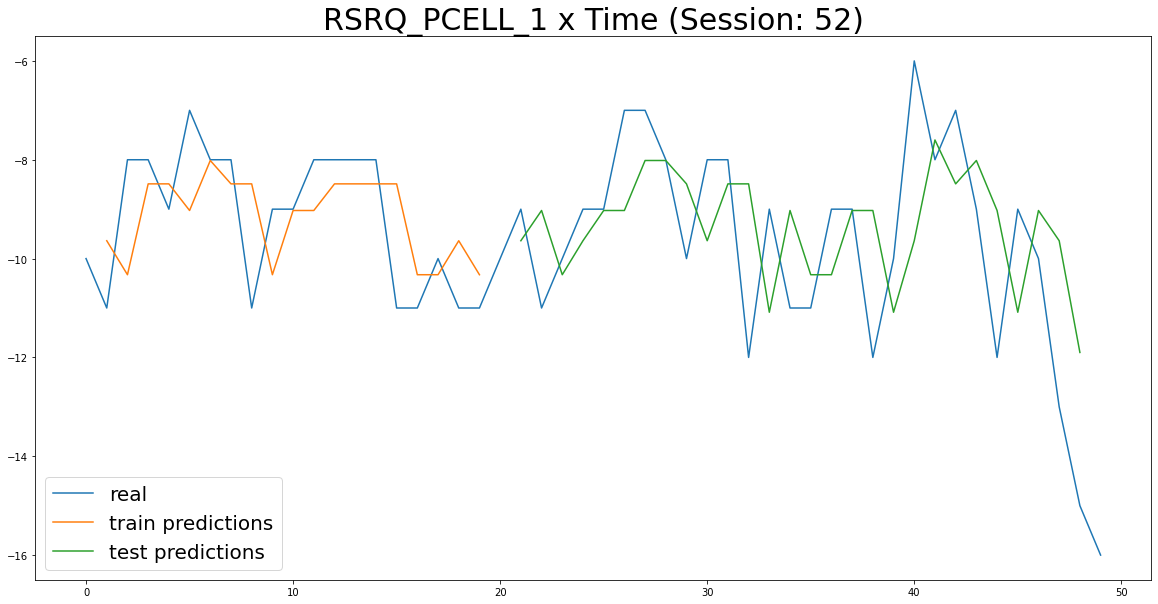

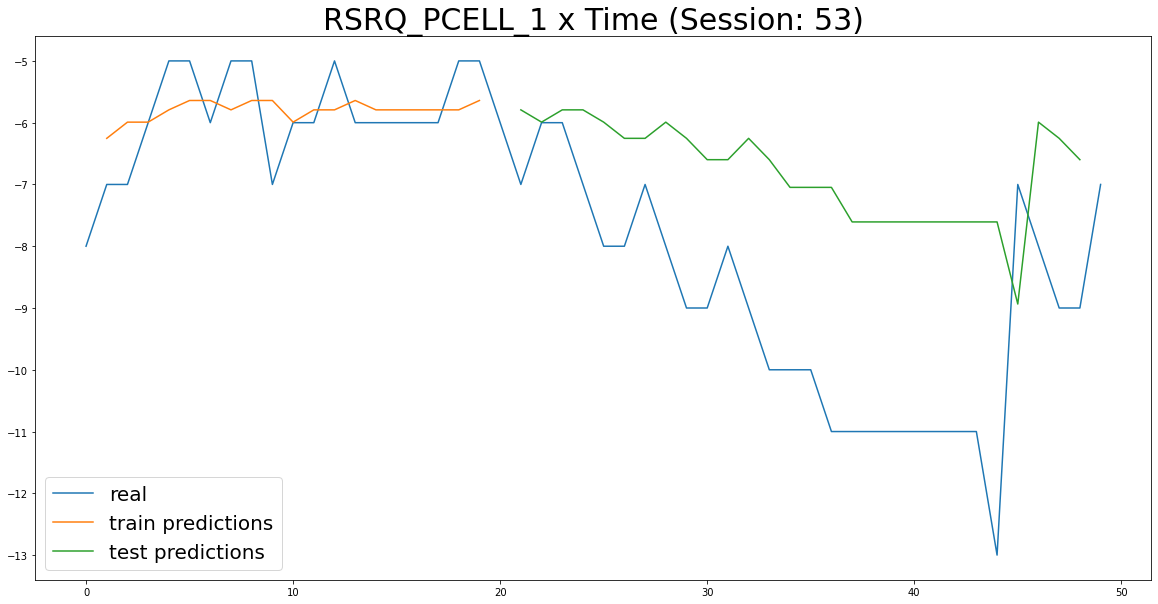

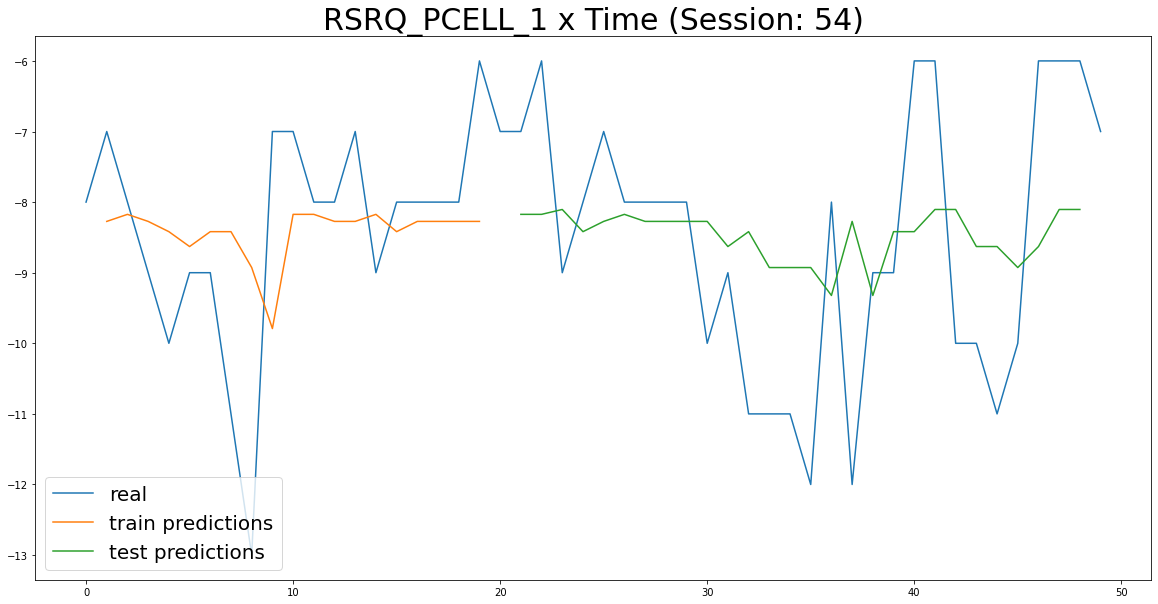

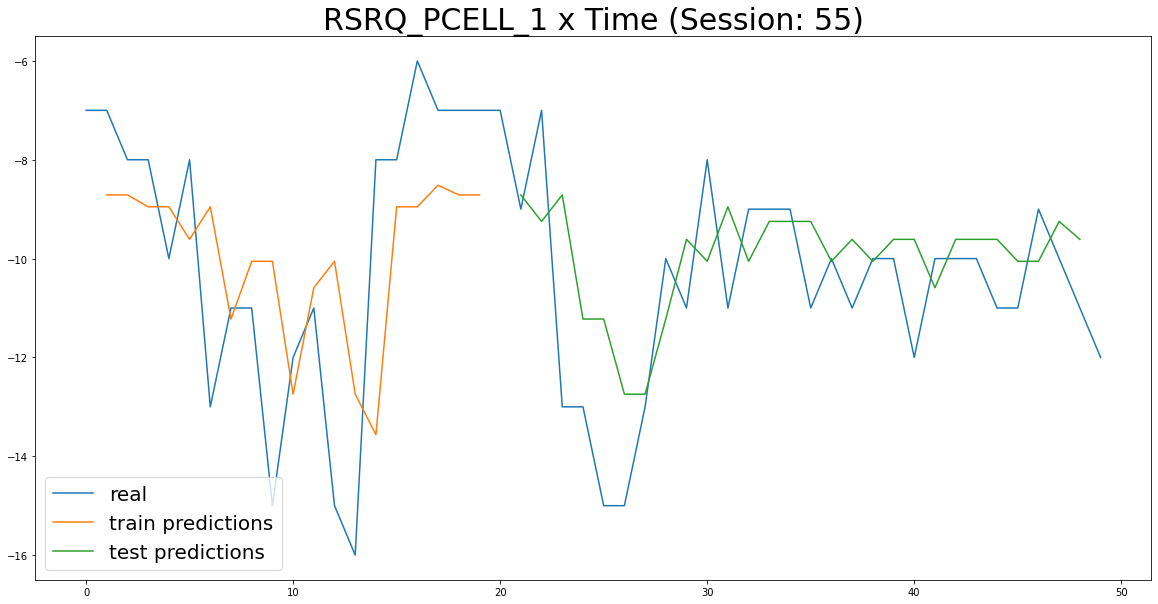

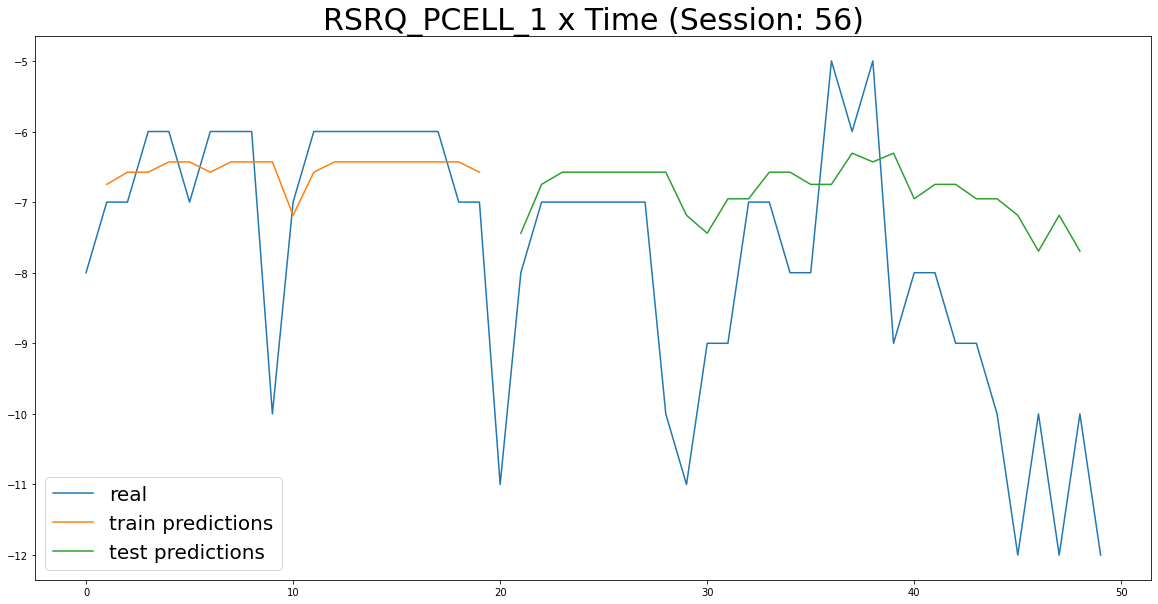

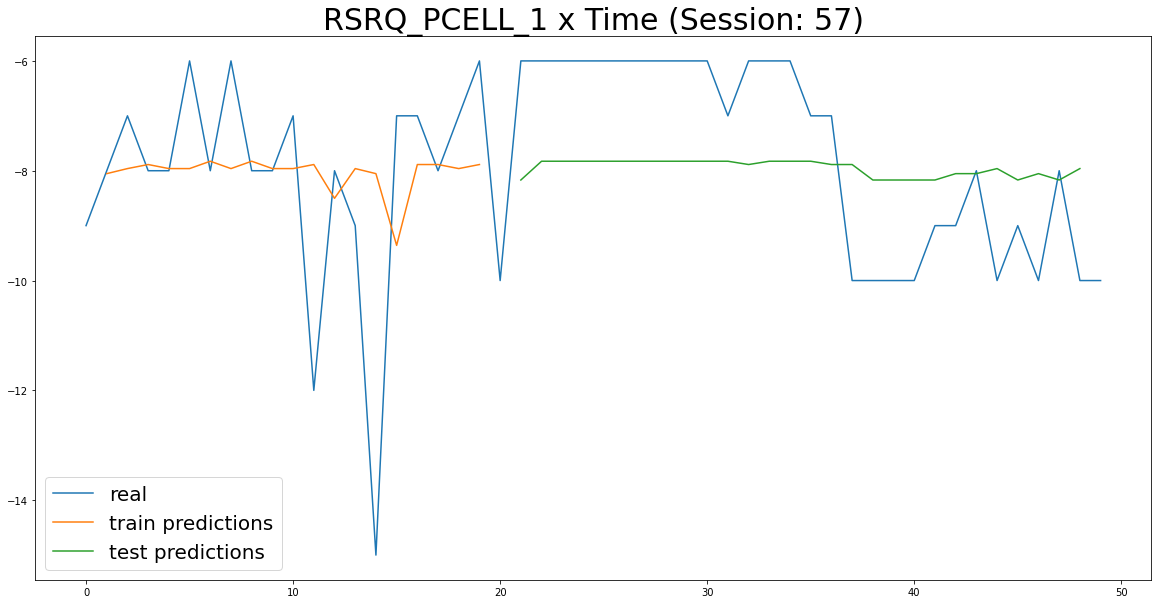

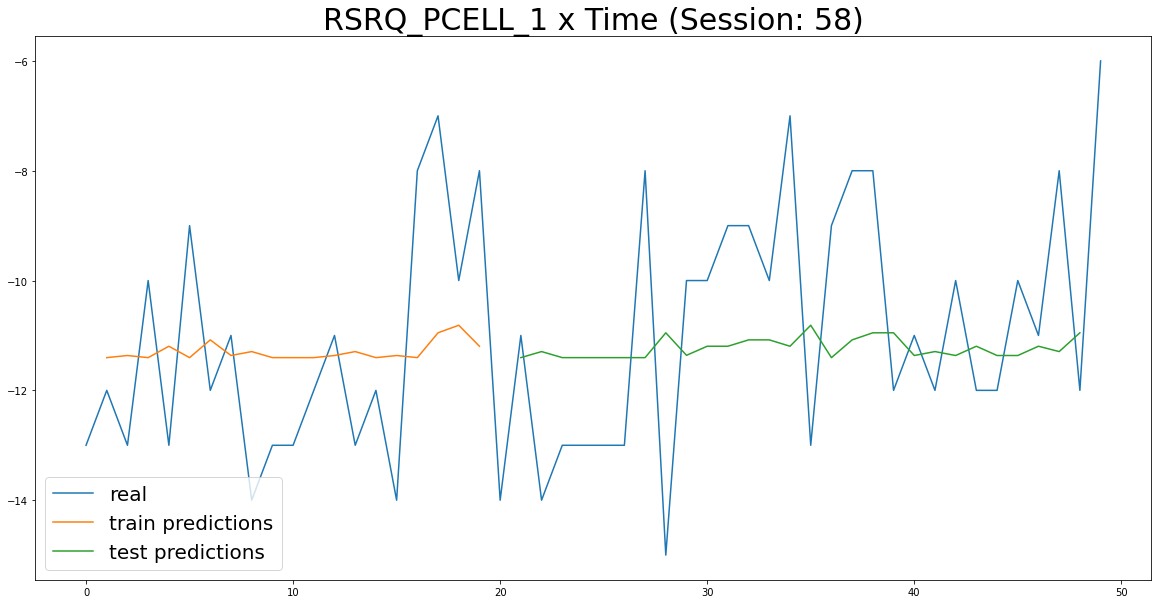

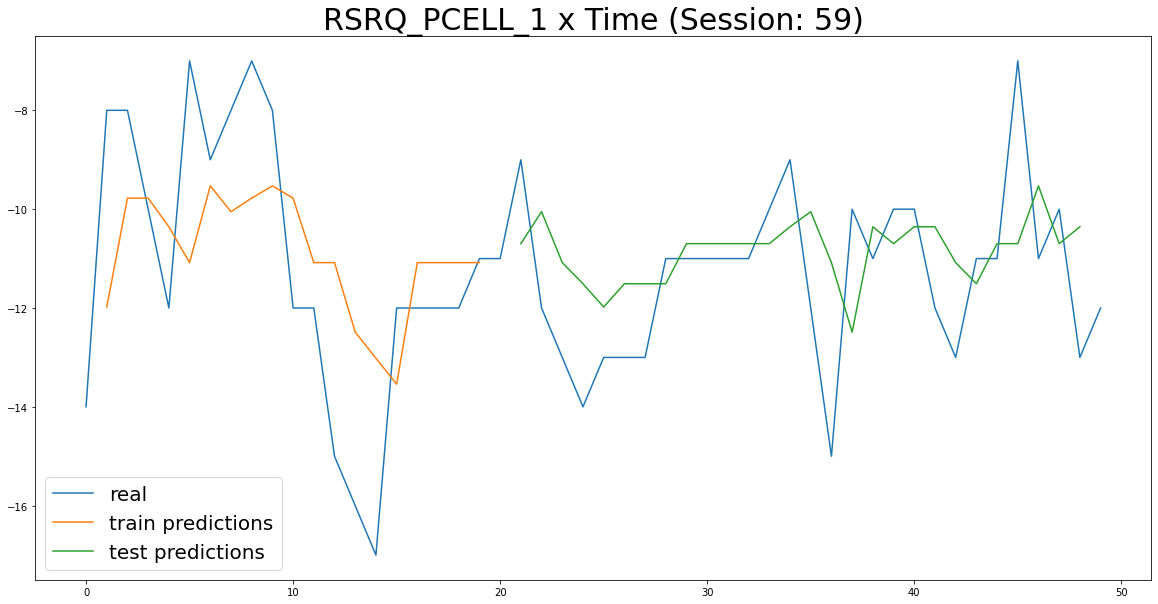

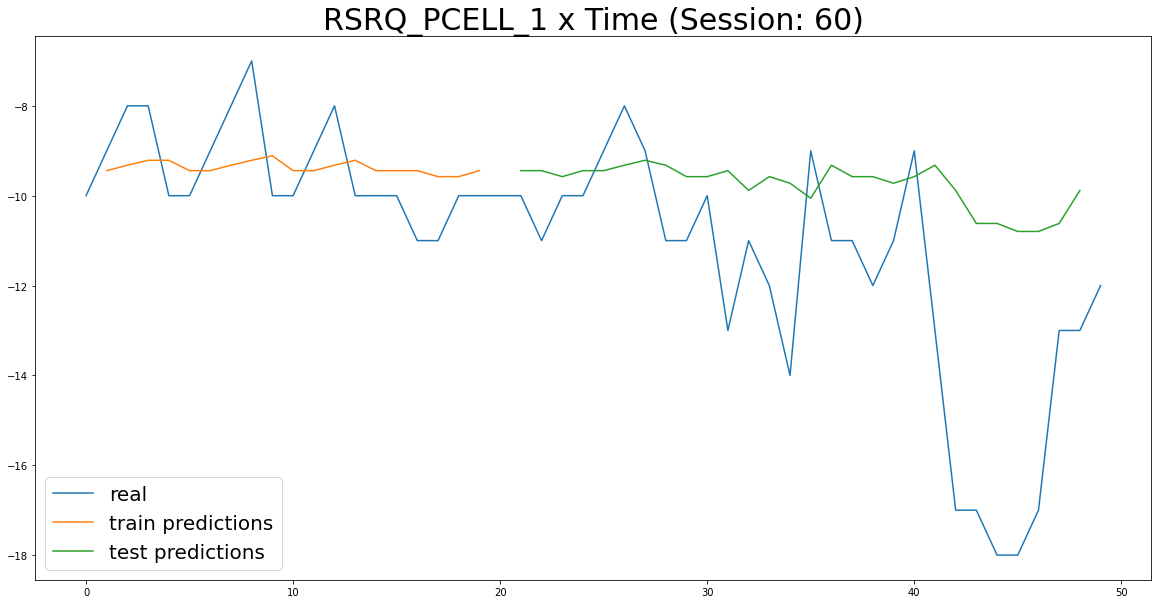

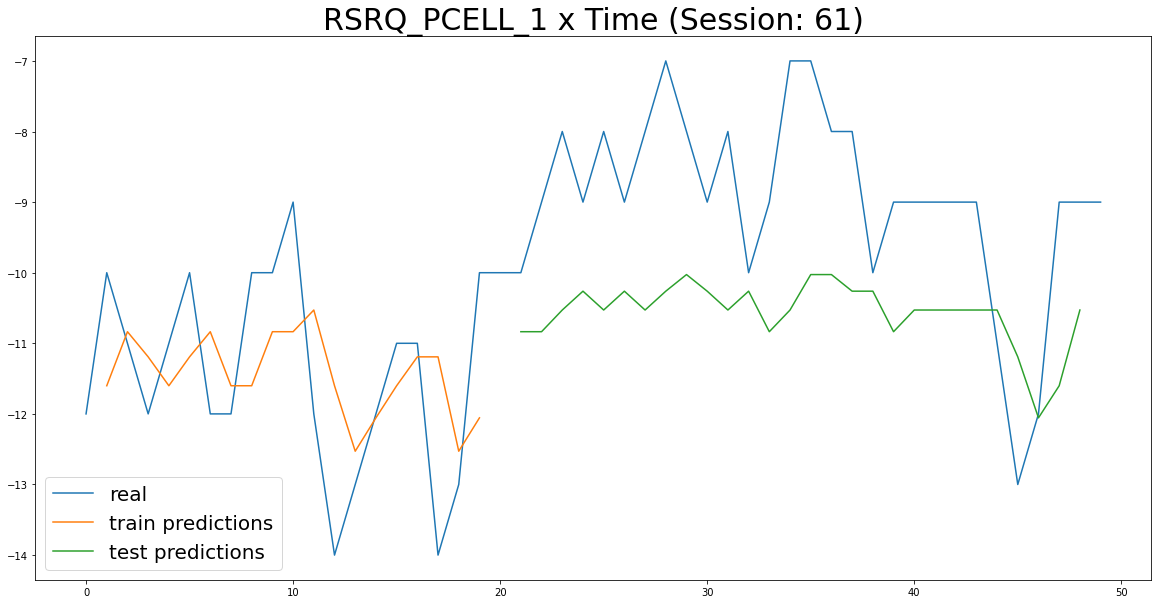

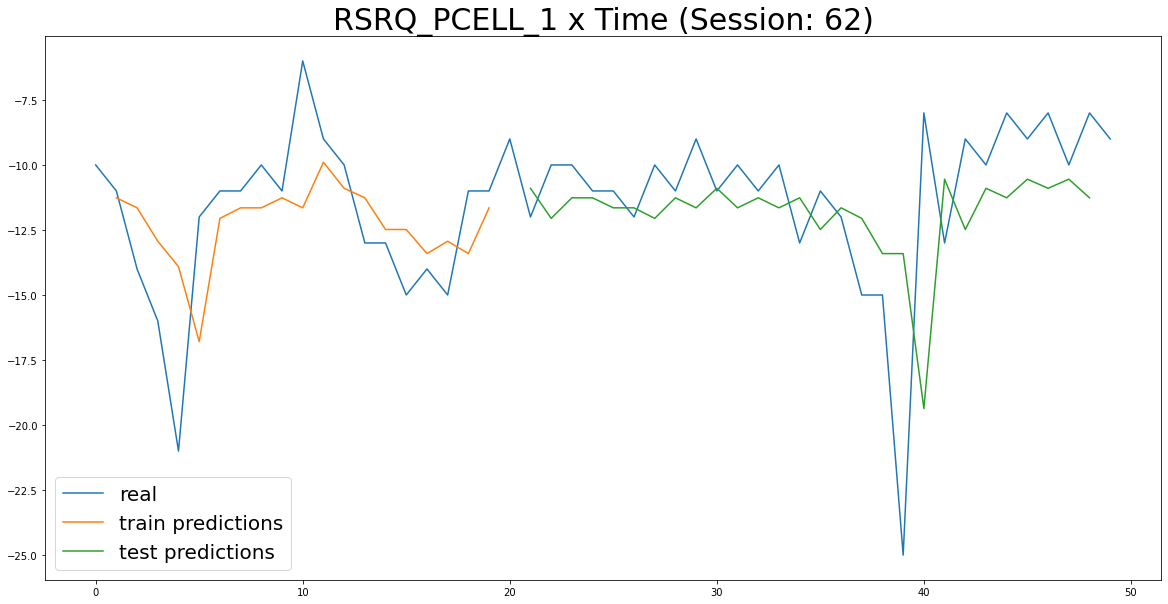

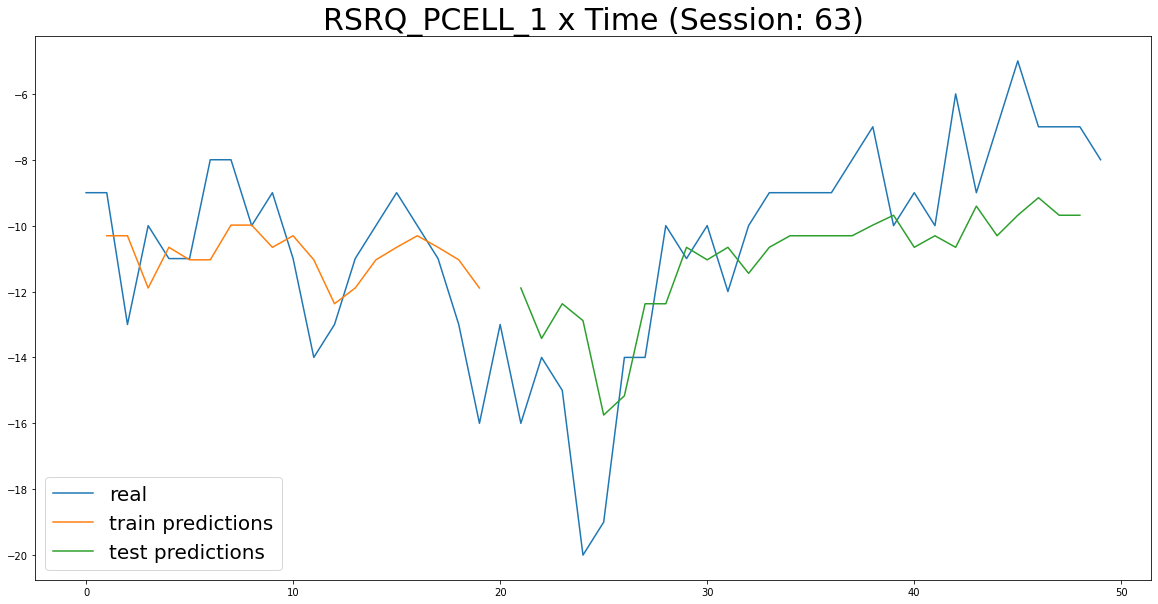

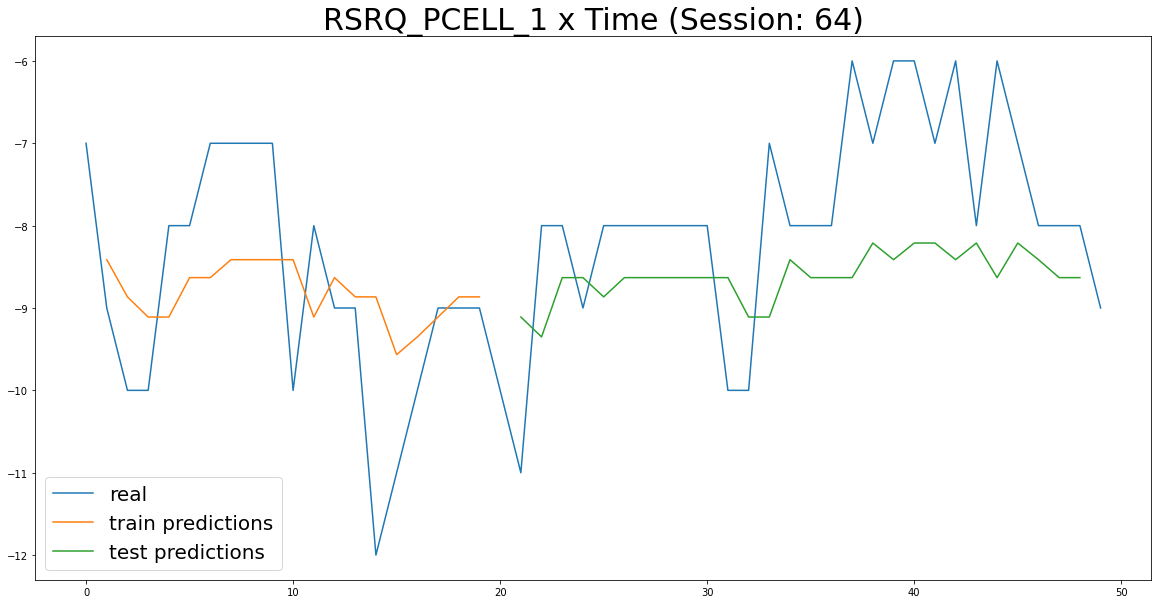

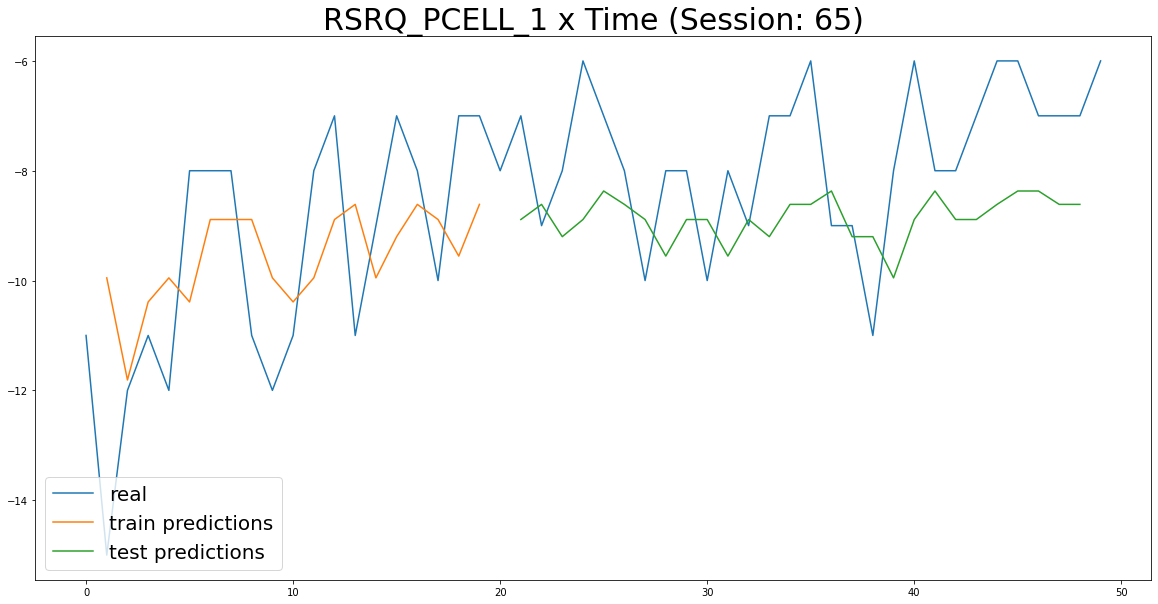

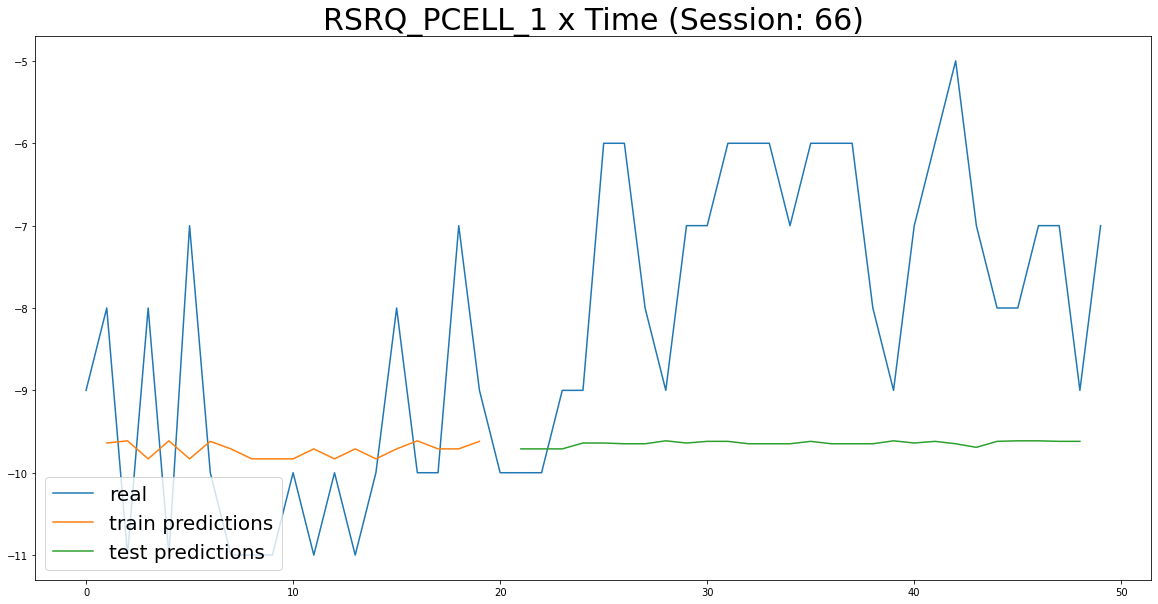

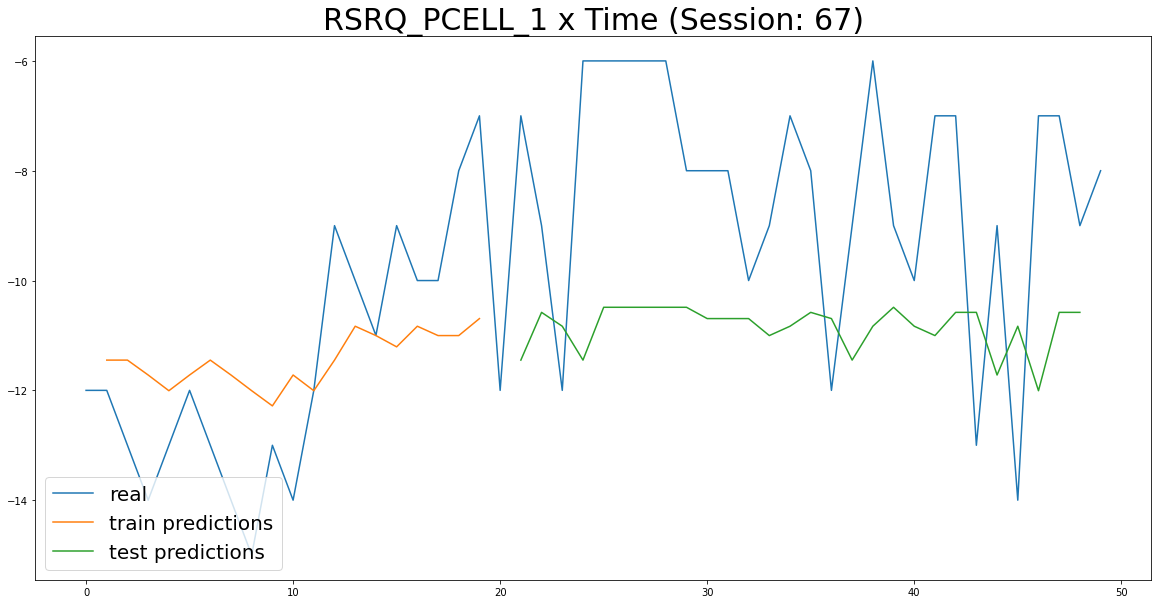

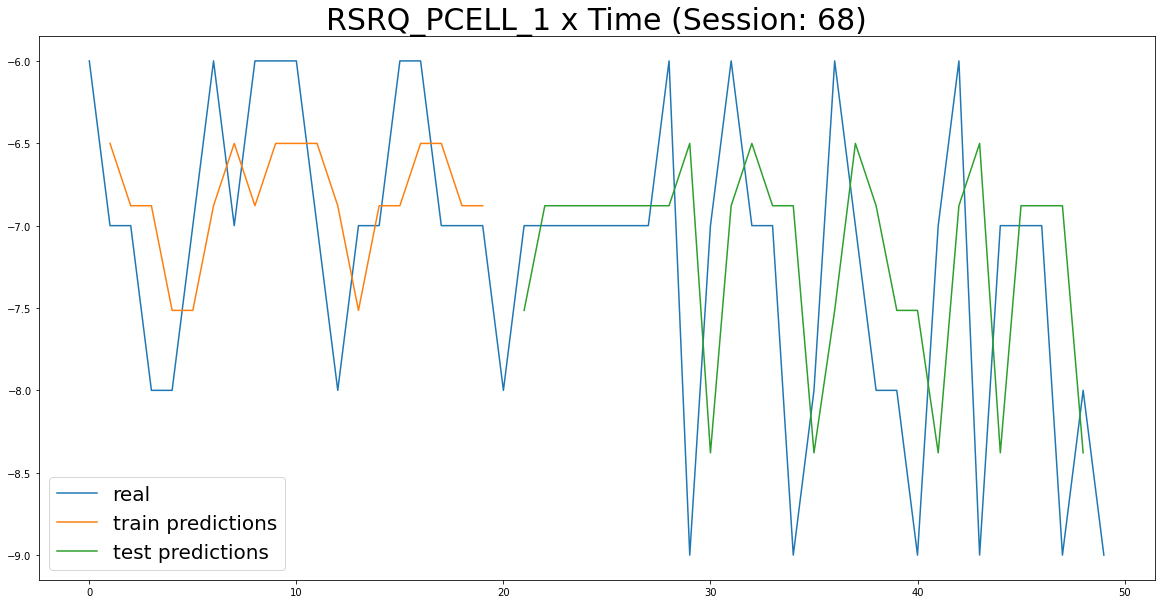

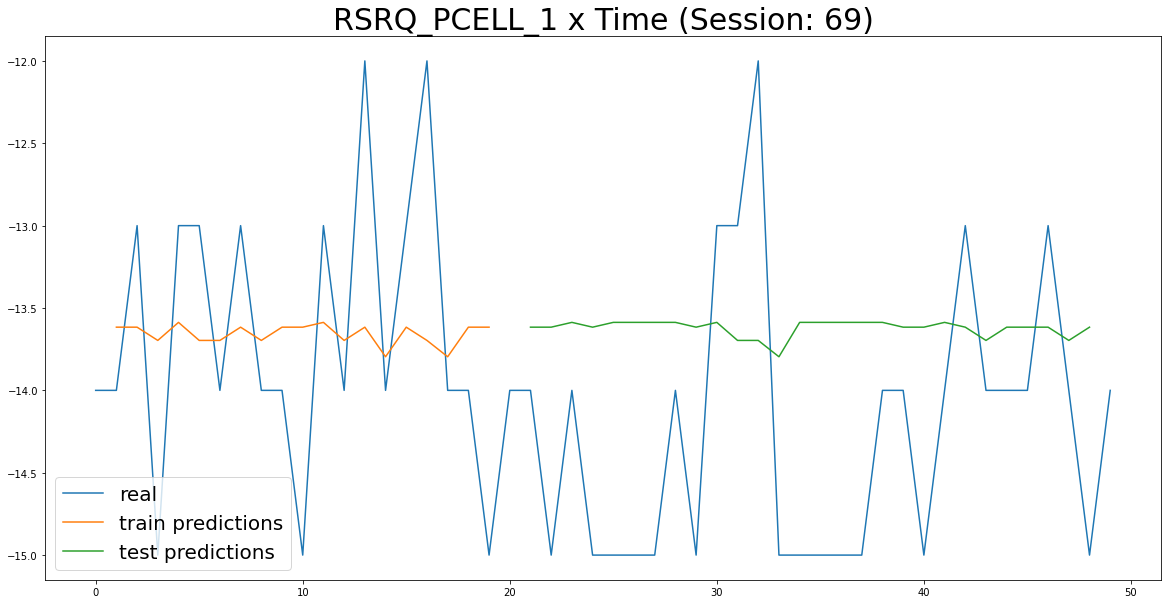

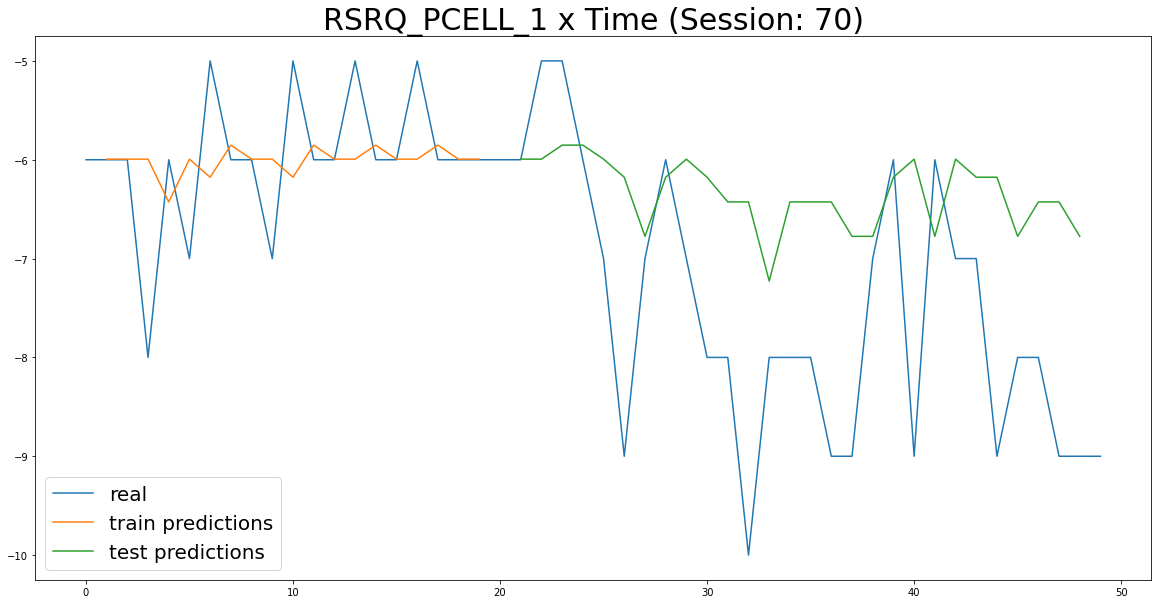

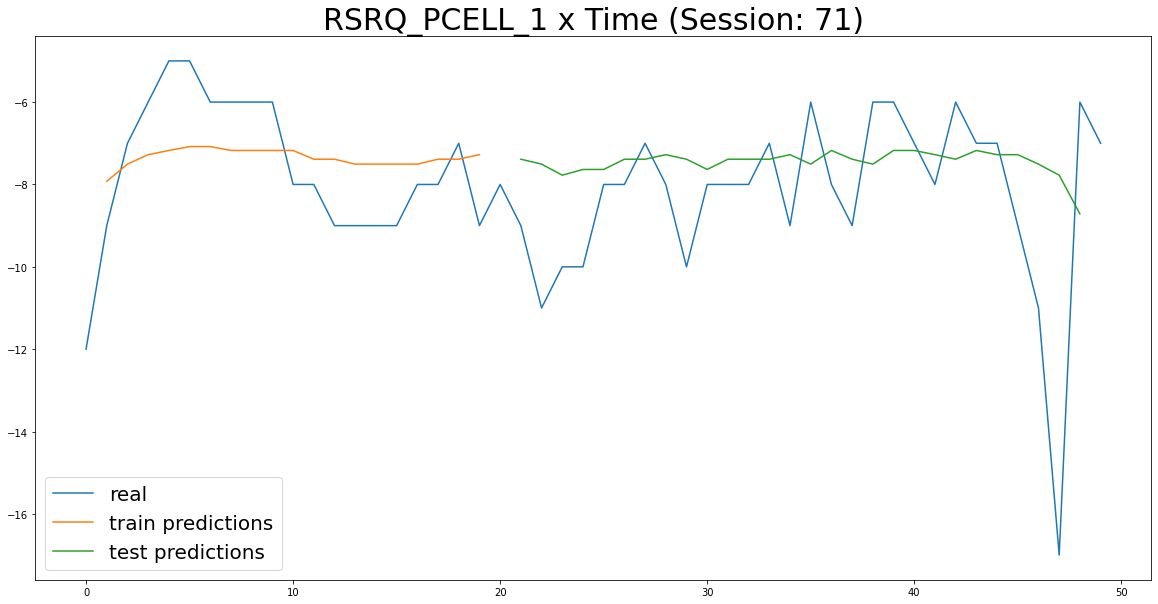

In [5]:
for i in range(len(datasetList)):
  fig, ax = plt.subplots(figsize = (20,10))
  ax.plot(datasetList[i])
  ax.plot(trainPredictPlotList[i])
  ax.plot(testPredictPlotList[i])
  plt.title("{0} x Time (Session: {1})".format(forecast_what, i), fontsize = 30)
  plt.legend(["real", "train predictions", "test predictions"], loc ="lower left", prop={"size": 20})
  plt.show()